# Import Libraries

In [1]:
import time
import numpy as np
# Torch
import torch
from torchvision import datasets, transforms
import torch.utils.data as Data
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
# Visualization
from matplotlib import pyplot as plt

In [2]:
# Dataloader
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

In [3]:
# Hyper parameters
batch_size = 1080
num_workers = 0
epoch = 2000
global lr
lr = 5e-3
device = 'cuda'

In [4]:
train_data, train_label, test_data, test_label = read_bci_data()
train_data = torch.from_numpy(train_data).to(device=device, dtype=torch.float)
train_label = torch.from_numpy(train_label).to(device=device, dtype=torch.float)
test_data = torch.from_numpy(test_data).to(device=device, dtype=torch.float)
test_label = torch.from_numpy(test_label).to(device=device, dtype=torch.float)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [5]:
train_tensor = Data.TensorDataset(train_data, train_label)
test_tensor = Data.TensorDataset(test_data, test_label)

train_loader = Data.DataLoader(
    dataset = train_tensor,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)

test_loader = Data.DataLoader(
    dataset = test_tensor,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)

In [6]:
class EEGNet(torch.nn.Module):
    def __init__(self, activation=0, f1=16, f2=32, fout=32, k1=51, k2=2, k3=15, do=0.25):
        super(EEGNet, self).__init__()
        # Activation:
        #   0 -> ELU
        #   1 -> ReLU
        #   2 -> LeakyReLU
        if activation == 0:
            self.firstConv = nn.Sequential(
                nn.Conv2d(1, f1, kernel_size=(1, k1), stride=(1, 1), padding=(0, 25), bias=False),
                nn.BatchNorm2d(f1, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
            )
            self.depthwiseConv = nn.Sequential(
                nn.Conv2d(f1, f2, kernel_size=(k2, 1), stride=(1, 1), groups=16, bias=False),
                nn.BatchNorm2d(f2, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
                nn.ELU(),
                nn.AvgPool2d(kernel_size=(1,4), stride=(1, 4), padding=0),
                nn.Dropout(p=do)
            )
            self.separableConv = nn.Sequential(
                nn.Conv2d(f2, fout, kernel_size=(1, k3), stride=(1, 1), padding=(0, 7), bias=False),
                nn.BatchNorm2d(fout, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
                nn.ELU(),
                nn.AvgPool2d(kernel_size=(1,8), stride=(1, 8), padding=0),
                nn.Dropout(p=do)
            )
            self.classify = nn.Sequential(
                nn.Linear(in_features=fout*23, out_features=2, bias=True)
            )
        elif activation == 1:
            self.firstConv = nn.Sequential(
                nn.Conv2d(1, f1, kernel_size=(1, k1), stride=(1, 1), padding=(0, 25), bias=False),
                nn.BatchNorm2d(f1, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
            )
            self.depthwiseConv = nn.Sequential(
                nn.Conv2d(f1, f2, kernel_size=(k2, 1), stride=(1, 1), groups=16, bias=False),
                nn.BatchNorm2d(f2, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=(1,4), stride=(1, 4), padding=0),
                nn.Dropout(p=do)
            )
            self.separableConv = nn.Sequential(
                nn.Conv2d(f2, fout, kernel_size=(1, k3), stride=(1, 1), padding=(0, 7), bias=False),
                nn.BatchNorm2d(fout, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=(1,8), stride=(1, 8), padding=0),
                nn.Dropout(p=do)
            )
            self.classify = nn.Sequential(
                nn.Linear(in_features=fout*23, out_features=2, bias=True)
            )
        else:
            self.firstConv = nn.Sequential(
                nn.Conv2d(1, f1, kernel_size=(1, k1), stride=(1, 1), padding=(0, 25), bias=False),
                nn.BatchNorm2d(f1, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
            )
            self.depthwiseConv = nn.Sequential(
                nn.Conv2d(f1, f2, kernel_size=(k2, 1), stride=(1, 1), groups=16, bias=False),
                nn.BatchNorm2d(f2, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
                nn.LeakyReLU(),
                nn.AvgPool2d(kernel_size=(1,4), stride=(1, 4), padding=0),
                nn.Dropout(p=do)
            )
            self.separableConv = nn.Sequential(
                nn.Conv2d(f2, fout, kernel_size=(1, k3), stride=(1, 1), padding=(0, 7), bias=False),
                nn.BatchNorm2d(fout, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
                nn.LeakyReLU(),
                nn.AvgPool2d(kernel_size=(1,8), stride=(1, 8), padding=0),
                nn.Dropout(p=do)
            )
            self.classify = nn.Sequential(
                nn.Linear(in_features=fout*23, out_features=2, bias=True)
            )
    def forward(self, x):
        res = self.firstConv(x)
        res = self.depthwiseConv(res)
        res = self.separableConv(res)
        res = res.view(res.size(0), -1)
        res = self.classify(res)
        return res

In [7]:
def train(model, epoch):
    model.train()
    loss_now = None
    for param_group in optimizer.param_groups:
            temp = param_group['lr'] 
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        target = target.long()
        
        optimizer.zero_grad()
        out = model(data)
        loss = Loss(out, target)
        loss.backward()
        optimizer.step()

        loss_now = loss.item()
    print('Training epoch: {}\t | lr: {}\t | Loss: {:.6f}'.format(epoch, temp, loss_now))
        
        

In [8]:
def test(model, epoch, activation_type, phase="Test"):
    if activation_type == 0:
        activation_str = "ELU"
    elif activation_type == 1:
        activation_str = "ReLU"
    else:
        activation_str = "LeakyReLU"
        
    if phase == "Test":
        data_loader = test_loader
        num = len(test_label)
    else: # train
        data_loader = train_loader
        num = len(train_label)
    correct_num = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        target = target.long()
        out = model(data)
        _, predicted = torch.max(out, 1)
        for i in range(len(target)):
            if predicted.cpu()[i] == target.cpu()[i]:
                correct_num += 1
    acc = correct_num/float(num)
    print("{} with activation type {} epoch: {}, accuracy: {:.2f}".format
          (phase, activation_str, epoch, acc))
    return acc

Training epoch: 1	 | lr: 0.005	 | Loss: 0.706864
-----------------------------------------------------------
Train with activation type ELU epoch: 1, accuracy: 0.65
Test with activation type ELU epoch: 1, accuracy: 0.66
-----------------------------------------------------------


/home/sean/.local/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type EEGNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Training epoch: 2	 | lr: 0.005	 | Loss: 0.601601
-----------------------------------------------------------
Train with activation type ELU epoch: 2, accuracy: 0.70
Test with activation type ELU epoch: 2, accuracy: 0.69
-----------------------------------------------------------
Training epoch: 3	 | lr: 0.005	 | Loss: 0.551152
-----------------------------------------------------------
Train with activation type ELU epoch: 3, accuracy: 0.72
Test with activation type ELU epoch: 3, accuracy: 0.68
-----------------------------------------------------------
Training epoch: 4	 | lr: 0.005	 | Loss: 0.547302
-----------------------------------------------------------
Train with activation type ELU epoch: 4, accuracy: 0.73
Test with activation type ELU epoch: 4, accuracy: 0.70
-----------------------------------------------------------
Training epoch: 5	 | lr: 0.005	 | Loss: 0.531757
-----------------------------------------------------------
Train with activation type ELU epoch: 5, accuracy: 

KeyboardInterrupt: 

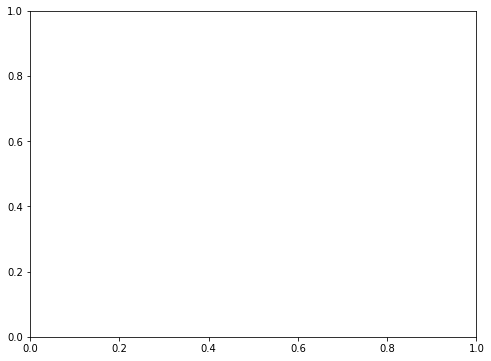

In [11]:
f1 = 16
f2 = 32
fout = 32
k1 = 51
k2 = 2
k3 = 16
do = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
ACC = []
for activation_type in range(3):
    model = EEGNet(activation_type, f1, f2, fout)
    model.to(device)
    # Define optimizer and loss function
    Loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    train_acc = []
    test_acc = []
    acc_max = 0
    for i in range(1, epoch+1):
        adjust_learning_rate(optimizer, i)
        train(model, i)
        print("-----------------------------------------------------------")
        acc = test(model, i, activation_type, "Train")
        train_acc.append(acc)
        acc = test(model, i, activation_type, "Test")
        test_acc.append(acc)
        print("-----------------------------------------------------------")
        if activation_type == 0:
            activation_str = "ELU"
        elif activation_type == 1:
            activation_str = "ReLU"
        else:
            activation_str = "LeakyReLU"
        if acc > acc_max:
            path = "model/eeg_activation_" + activation_str + "_iteration_{}_acc_{:.3f}_lr_{}.pth".format(
                i, acc, lr)
            torch.save(model, path)
            acc_max = acc
        train_str = "Training acc. with " + activation_str
        test_str = "Testing acc. with " + activation_str
    ACC.append(train_acc)
    ACC.append(test_acc)
    ax.plot(train_acc, label=train_str)
    ax.plot(test_acc, label=test_str)    
ax.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Accuacy (%)")
plt.title("result_eeg")
plt.savefig("result_eeg.png")
plt.show()


In [10]:
acc = np.array(ACC)
print(np.max(acc[1]))
print(np.max(acc[3]))
print(np.max(acc[5]))

0.8361111111111111
0.8722222222222222
0.8657407407407407


In [11]:
np.argmax(acc[3])

1673

In [12]:
acc[3][810]

0.8277777777777777

# DeepConvNet

In [21]:
class DCN(torch.nn.Module):
    def __init__(self, activation, f1=25, f2=25, f3=50, f4 = 100, fout=200, 
                 k1=5, k2=2, k3=5, k4=5, k5=5, do=0.5):
        super(DCN, self).__init__()
        # Activation:
        #   0 -> ELU
        #   1 -> ReLU
        #   2 -> LeakyReLU
        self.conv1 = nn.Conv2d(1, f1, kernel_size = (1, k1))
        self.conv2 = nn.Conv2d(f1, f2, kernel_size = (k2, 1))
        self.conv3 = nn.Conv2d(f2, f3, kernel_size = (1, k3))
        self.conv4 = nn.Conv2d(f3, f4, kernel_size = (1, k4))
        self.conv5 = nn.Conv2d(f4, fout, kernel_size = (1, k5))
        self.dropout = nn.Dropout(p=do)
        self.maxpool = nn.MaxPool2d(kernel_size = (1, 2))
        self.batch_norm_1 = nn.BatchNorm2d(f1)
        self.batch_norm_2 = nn.BatchNorm2d(f3)
        self.batch_norm_3 = nn.BatchNorm2d(f4)
        self.batch_norm_4 = nn.BatchNorm2d(fout)
        if activation == 0:
            self.activation = nn.ELU()
        elif activation == 1:
            self.activation = nn.ReLU()
        else:
            self.activation = nn.LeakyReLU()
        self.classify = nn.Linear(fout*37, 2)
        
    def forward(self, x):
        res = self.conv1(x) # 25*2*746
        res = self.conv2(res) # 25*1*746
        res = self.batch_norm_1(res) # 25*1*746
        res = self.activation(res) # 25*1*746
        res = self.maxpool(res) # 25*1*373
        res = self.dropout(res) # 25*1*373
        ##############################
        res = self.conv3(res) # 50*1*369
        res = self.batch_norm_2(res) # 50*1*369
        res = self.activation(res) # 50*1*369
        res = self.maxpool(res) # 50*1*184
        res = self.dropout(res) # 50*1*184
        ##############################
        res = self.conv4(res) # 100*1*180
        res = self.batch_norm_3(res) # 100*1*180
        res = self.activation(res) # 100*1*180
        res = self.maxpool(res) # 100*1*90
        res = self.dropout(res) # 100*1*90
        ##############################
        res = self.conv5(res) # 200*1*86
        res = self.batch_norm_4(res) # 200*1*86
        res = self.activation(res) # 200*1*86
        res = self.maxpool(res) # 200*1*43
        res = self.dropout(res) # 200*1*43
        ##############################
        res = res.view(res.size(0), -1)
        res = self.classify(res)
        return res

In [32]:
epoch = 1000

In [10]:
# 0 < epoch < 1000: 0.005
# 1000 < epoch < 1500: 0.0025
# 1500 < epoch < 2000: 0.00125
def adjust_learning_rate(optimizer, epoch):
    if epoch > 500 and epoch < 1000:
        global lr
        lr = 0.0025
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epoch > 1000 and epoch < 1500:
        global lr
        lr = 0.00125
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epoch > 1500 and epoch < 2000:
        global lr
        lr = 0.000625
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

<>:11: SyntaxWarning: name 'lr' is assigned to before global declaration
<>:16: SyntaxWarning: name 'lr' is assigned to before global declaration
<>:11: SyntaxWarning: name 'lr' is assigned to before global declaration
<>:16: SyntaxWarning: name 'lr' is assigned to before global declaration
<>:11: SyntaxWarning: name 'lr' is assigned to before global declaration
<>:16: SyntaxWarning: name 'lr' is assigned to before global declaration
<ipython-input-10-2560b8dc109f>:11: SyntaxWarning: name 'lr' is assigned to before global declaration
  global lr
<ipython-input-10-2560b8dc109f>:16: SyntaxWarning: name 'lr' is assigned to before global declaration
  global lr


Training epoch: 1	 | lr: 0.005	 | Loss: 0.739226
-----------------------------------------------------------
Train with activation type ELU epoch: 1, accuracy: 0.50
Test with activation type ELU epoch: 1, accuracy: 0.50
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 32.973157465457916 min
Training epoch: 2	 | lr: 0.005	 | Loss: 4.062108
-----------------------------------------------------------
Train with activation type ELU epoch: 2, accuracy: 0.62
Test with activation type ELU epoch: 2, accuracy: 0.63
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 33.379081988334654 min
Training epoch: 3	 | lr: 0.005	 | Loss: 0.723439
-----------------------------------------------------------
Train with activation type ELU epoch: 3, accuracy: 0.59
Test with activation type ELU epoch: 3, accuracy: 0.62
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 30.949416613578798 min
Training epoc

Training epoch: 26	 | lr: 0.005	 | Loss: 0.568883
-----------------------------------------------------------
Train with activation type ELU epoch: 26, accuracy: 0.70
Test with activation type ELU epoch: 26, accuracy: 0.68
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 34.04458424250285 min
Training epoch: 27	 | lr: 0.005	 | Loss: 0.568704
-----------------------------------------------------------
Train with activation type ELU epoch: 27, accuracy: 0.72
Test with activation type ELU epoch: 27, accuracy: 0.68
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 31.533488023281098 min
Training epoch: 28	 | lr: 0.005	 | Loss: 0.569312
-----------------------------------------------------------
Train with activation type ELU epoch: 28, accuracy: 0.71
Test with activation type ELU epoch: 28, accuracy: 0.69
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 31.180531724294028 min
Train

Training epoch: 51	 | lr: 0.005	 | Loss: 0.504048
-----------------------------------------------------------
Train with activation type ELU epoch: 51, accuracy: 0.75
Test with activation type ELU epoch: 51, accuracy: 0.70
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 31.907131254673004 min
Training epoch: 52	 | lr: 0.005	 | Loss: 0.510639
-----------------------------------------------------------
Train with activation type ELU epoch: 52, accuracy: 0.75
Test with activation type ELU epoch: 52, accuracy: 0.71
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 30.710623200734457 min
Training epoch: 53	 | lr: 0.005	 | Loss: 0.506051
-----------------------------------------------------------
Train with activation type ELU epoch: 53, accuracy: 0.75
Test with activation type ELU epoch: 53, accuracy: 0.71
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 31.269041812419893 min
Trai

Training epoch: 76	 | lr: 0.005	 | Loss: 0.427793
-----------------------------------------------------------
Train with activation type ELU epoch: 76, accuracy: 0.80
Test with activation type ELU epoch: 76, accuracy: 0.77
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 31.161903270085652 min
Training epoch: 77	 | lr: 0.005	 | Loss: 0.423669
-----------------------------------------------------------
Train with activation type ELU epoch: 77, accuracy: 0.79
Test with activation type ELU epoch: 77, accuracy: 0.76
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 32.961822017033896 min
Training epoch: 78	 | lr: 0.005	 | Loss: 0.438137
-----------------------------------------------------------
Train with activation type ELU epoch: 78, accuracy: 0.81
Test with activation type ELU epoch: 78, accuracy: 0.78
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 30.696346092224122 min
Trai

Training epoch: 101	 | lr: 0.005	 | Loss: 0.336195
-----------------------------------------------------------
Train with activation type ELU epoch: 101, accuracy: 0.85
Test with activation type ELU epoch: 101, accuracy: 0.79
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 30.783309729894004 min
Training epoch: 102	 | lr: 0.005	 | Loss: 0.334422
-----------------------------------------------------------
Train with activation type ELU epoch: 102, accuracy: 0.84
Test with activation type ELU epoch: 102, accuracy: 0.78
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 30.319906854629515 min
Training epoch: 103	 | lr: 0.005	 | Loss: 0.344852
-----------------------------------------------------------
Train with activation type ELU epoch: 103, accuracy: 0.87
Test with activation type ELU epoch: 103, accuracy: 0.78
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 30.460423016548155

Training epoch: 125	 | lr: 0.005	 | Loss: 0.310998
-----------------------------------------------------------
Train with activation type ELU epoch: 125, accuracy: 0.87
Test with activation type ELU epoch: 125, accuracy: 0.79
-----------------------------------------------------------
acc_max is now: 0.812037037037037, ETA: 30.263768633206684 min
Training epoch: 126	 | lr: 0.005	 | Loss: 0.294610
-----------------------------------------------------------
Train with activation type ELU epoch: 126, accuracy: 0.88
Test with activation type ELU epoch: 126, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.812037037037037, ETA: 30.370935106277464 min
Training epoch: 127	 | lr: 0.005	 | Loss: 0.287360
-----------------------------------------------------------
Train with activation type ELU epoch: 127, accuracy: 0.88
Test with activation type ELU epoch: 127, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 

Training epoch: 149	 | lr: 0.005	 | Loss: 0.260296
-----------------------------------------------------------
Train with activation type ELU epoch: 149, accuracy: 0.90
Test with activation type ELU epoch: 149, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.825925925925926, ETA: 30.236485028266905 min
Training epoch: 150	 | lr: 0.005	 | Loss: 0.248467
-----------------------------------------------------------
Train with activation type ELU epoch: 150, accuracy: 0.88
Test with activation type ELU epoch: 150, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.825925925925926, ETA: 30.1981920003891 min
Training epoch: 151	 | lr: 0.005	 | Loss: 0.289704
-----------------------------------------------------------
Train with activation type ELU epoch: 151, accuracy: 0.89
Test with activation type ELU epoch: 151, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.

Training epoch: 173	 | lr: 0.005	 | Loss: 0.224655
-----------------------------------------------------------
Train with activation type ELU epoch: 173, accuracy: 0.90
Test with activation type ELU epoch: 173, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8277777777777777, ETA: 31.272425973415373 min
Training epoch: 174	 | lr: 0.005	 | Loss: 0.210003
-----------------------------------------------------------
Train with activation type ELU epoch: 174, accuracy: 0.91
Test with activation type ELU epoch: 174, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8277777777777777, ETA: 31.94242706298828 min
Training epoch: 175	 | lr: 0.005	 | Loss: 0.216900
-----------------------------------------------------------
Train with activation type ELU epoch: 175, accuracy: 0.90
Test with activation type ELU epoch: 175, accuracy: 0.81
-----------------------------------------------------------
acc_max is now:

Training epoch: 197	 | lr: 0.005	 | Loss: 0.217416
-----------------------------------------------------------
Train with activation type ELU epoch: 197, accuracy: 0.91
Test with activation type ELU epoch: 197, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8277777777777777, ETA: 30.18420453071594 min
Training epoch: 198	 | lr: 0.005	 | Loss: 0.204202
-----------------------------------------------------------
Train with activation type ELU epoch: 198, accuracy: 0.92
Test with activation type ELU epoch: 198, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8277777777777777, ETA: 30.321414256095885 min
Training epoch: 199	 | lr: 0.005	 | Loss: 0.203292
-----------------------------------------------------------
Train with activation type ELU epoch: 199, accuracy: 0.91
Test with activation type ELU epoch: 199, accuracy: 0.81
-----------------------------------------------------------
acc_max is now:

Training epoch: 221	 | lr: 0.005	 | Loss: 0.170167
-----------------------------------------------------------
Train with activation type ELU epoch: 221, accuracy: 0.93
Test with activation type ELU epoch: 221, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8342592592592593, ETA: 29.95913246870041 min
Training epoch: 222	 | lr: 0.005	 | Loss: 0.176883
-----------------------------------------------------------
Train with activation type ELU epoch: 222, accuracy: 0.93
Test with activation type ELU epoch: 222, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8342592592592593, ETA: 30.10268132686615 min
Training epoch: 223	 | lr: 0.005	 | Loss: 0.193179
-----------------------------------------------------------
Train with activation type ELU epoch: 223, accuracy: 0.94
Test with activation type ELU epoch: 223, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 

Training epoch: 245	 | lr: 0.005	 | Loss: 0.143577
-----------------------------------------------------------
Train with activation type ELU epoch: 245, accuracy: 0.94
Test with activation type ELU epoch: 245, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8342592592592593, ETA: 30.061132351557415 min
Training epoch: 246	 | lr: 0.005	 | Loss: 0.148851
-----------------------------------------------------------
Train with activation type ELU epoch: 246, accuracy: 0.95
Test with activation type ELU epoch: 246, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8342592592592593, ETA: 29.77579782009125 min
Training epoch: 247	 | lr: 0.005	 | Loss: 0.124673
-----------------------------------------------------------
Train with activation type ELU epoch: 247, accuracy: 0.95
Test with activation type ELU epoch: 247, accuracy: 0.81
-----------------------------------------------------------
acc_max is now:

Training epoch: 269	 | lr: 0.005	 | Loss: 0.099095
-----------------------------------------------------------
Train with activation type ELU epoch: 269, accuracy: 0.95
Test with activation type ELU epoch: 269, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8342592592592593, ETA: 30.035058863957723 min
Training epoch: 270	 | lr: 0.005	 | Loss: 0.108789
-----------------------------------------------------------
Train with activation type ELU epoch: 270, accuracy: 0.96
Test with activation type ELU epoch: 270, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8342592592592593, ETA: 30.085328817367554 min
Training epoch: 271	 | lr: 0.005	 | Loss: 0.111874
-----------------------------------------------------------
Train with activation type ELU epoch: 271, accuracy: 0.95
Test with activation type ELU epoch: 271, accuracy: 0.82
-----------------------------------------------------------
acc_max is now

Training epoch: 293	 | lr: 0.005	 | Loss: 0.116136
-----------------------------------------------------------
Train with activation type ELU epoch: 293, accuracy: 0.96
Test with activation type ELU epoch: 293, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8361111111111111, ETA: 29.646695816516875 min
Training epoch: 294	 | lr: 0.005	 | Loss: 0.100979
-----------------------------------------------------------
Train with activation type ELU epoch: 294, accuracy: 0.95
Test with activation type ELU epoch: 294, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8361111111111111, ETA: 29.698751878738403 min
Training epoch: 295	 | lr: 0.005	 | Loss: 0.097915
-----------------------------------------------------------
Train with activation type ELU epoch: 295, accuracy: 0.96
Test with activation type ELU epoch: 295, accuracy: 0.82
-----------------------------------------------------------
acc_max is now

Training epoch: 317	 | lr: 0.005	 | Loss: 0.090446
-----------------------------------------------------------
Train with activation type ELU epoch: 317, accuracy: 0.97
Test with activation type ELU epoch: 317, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 30.38177074988683 min
Training epoch: 318	 | lr: 0.005	 | Loss: 0.075148
-----------------------------------------------------------
Train with activation type ELU epoch: 318, accuracy: 0.97
Test with activation type ELU epoch: 318, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 30.29787497520447 min
Training epoch: 319	 | lr: 0.005	 | Loss: 0.088530
-----------------------------------------------------------
Train with activation type ELU epoch: 319, accuracy: 0.96
Test with activation type ELU epoch: 319, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 

Training epoch: 341	 | lr: 0.005	 | Loss: 0.055251
-----------------------------------------------------------
Train with activation type ELU epoch: 341, accuracy: 0.97
Test with activation type ELU epoch: 341, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.61746938228607 min
Training epoch: 342	 | lr: 0.005	 | Loss: 0.077024
-----------------------------------------------------------
Train with activation type ELU epoch: 342, accuracy: 0.98
Test with activation type ELU epoch: 342, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.39471390247345 min
Training epoch: 343	 | lr: 0.005	 | Loss: 0.070089
-----------------------------------------------------------
Train with activation type ELU epoch: 343, accuracy: 0.97
Test with activation type ELU epoch: 343, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 

Training epoch: 365	 | lr: 0.005	 | Loss: 0.061863
-----------------------------------------------------------
Train with activation type ELU epoch: 365, accuracy: 0.97
Test with activation type ELU epoch: 365, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.471954723199207 min
Training epoch: 366	 | lr: 0.005	 | Loss: 0.058546
-----------------------------------------------------------
Train with activation type ELU epoch: 366, accuracy: 0.98
Test with activation type ELU epoch: 366, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.211954760551453 min
Training epoch: 367	 | lr: 0.005	 | Loss: 0.066636
-----------------------------------------------------------
Train with activation type ELU epoch: 367, accuracy: 0.97
Test with activation type ELU epoch: 367, accuracy: 0.81
-----------------------------------------------------------
acc_max is now

Training epoch: 389	 | lr: 0.005	 | Loss: 0.068552
-----------------------------------------------------------
Train with activation type ELU epoch: 389, accuracy: 0.98
Test with activation type ELU epoch: 389, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 30.40723522901535 min
Training epoch: 390	 | lr: 0.005	 | Loss: 0.049682
-----------------------------------------------------------
Train with activation type ELU epoch: 390, accuracy: 0.98
Test with activation type ELU epoch: 390, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 30.816828727722168 min
Training epoch: 391	 | lr: 0.005	 | Loss: 0.045149
-----------------------------------------------------------
Train with activation type ELU epoch: 391, accuracy: 0.98
Test with activation type ELU epoch: 391, accuracy: 0.80
-----------------------------------------------------------
acc_max is now:

Training epoch: 413	 | lr: 0.005	 | Loss: 0.045320
-----------------------------------------------------------
Train with activation type ELU epoch: 413, accuracy: 0.98
Test with activation type ELU epoch: 413, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.932196633021036 min
Training epoch: 414	 | lr: 0.005	 | Loss: 0.046375
-----------------------------------------------------------
Train with activation type ELU epoch: 414, accuracy: 0.99
Test with activation type ELU epoch: 414, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.989522838592528 min
Training epoch: 415	 | lr: 0.005	 | Loss: 0.041276
-----------------------------------------------------------
Train with activation type ELU epoch: 415, accuracy: 0.98
Test with activation type ELU epoch: 415, accuracy: 0.83
-----------------------------------------------------------
acc_max is now

Training epoch: 437	 | lr: 0.005	 | Loss: 0.035309
-----------------------------------------------------------
Train with activation type ELU epoch: 437, accuracy: 0.99
Test with activation type ELU epoch: 437, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.795946737130482 min
Training epoch: 438	 | lr: 0.005	 | Loss: 0.042594
-----------------------------------------------------------
Train with activation type ELU epoch: 438, accuracy: 0.99
Test with activation type ELU epoch: 438, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.94240517616272 min
Training epoch: 439	 | lr: 0.005	 | Loss: 0.037602
-----------------------------------------------------------
Train with activation type ELU epoch: 439, accuracy: 0.99
Test with activation type ELU epoch: 439, accuracy: 0.82
-----------------------------------------------------------
acc_max is now:

Training epoch: 461	 | lr: 0.005	 | Loss: 0.030399
-----------------------------------------------------------
Train with activation type ELU epoch: 461, accuracy: 0.99
Test with activation type ELU epoch: 461, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 30.195992863178255 min
Training epoch: 462	 | lr: 0.005	 | Loss: 0.031345
-----------------------------------------------------------
Train with activation type ELU epoch: 462, accuracy: 0.99
Test with activation type ELU epoch: 462, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.792276120185853 min
Training epoch: 463	 | lr: 0.005	 | Loss: 0.044552
-----------------------------------------------------------
Train with activation type ELU epoch: 463, accuracy: 0.98
Test with activation type ELU epoch: 463, accuracy: 0.80
-----------------------------------------------------------
acc_max is now

Training epoch: 485	 | lr: 0.005	 | Loss: 0.030480
-----------------------------------------------------------
Train with activation type ELU epoch: 485, accuracy: 0.97
Test with activation type ELU epoch: 485, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.756050268809002 min
Training epoch: 486	 | lr: 0.005	 | Loss: 0.043013
-----------------------------------------------------------
Train with activation type ELU epoch: 486, accuracy: 1.00
Test with activation type ELU epoch: 486, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.549120473861695 min
Training epoch: 487	 | lr: 0.005	 | Loss: 0.024401
-----------------------------------------------------------
Train with activation type ELU epoch: 487, accuracy: 0.99
Test with activation type ELU epoch: 487, accuracy: 0.81
-----------------------------------------------------------
acc_max is now

Training epoch: 509	 | lr: 0.0025	 | Loss: 0.024788
-----------------------------------------------------------
Train with activation type ELU epoch: 509, accuracy: 0.99
Test with activation type ELU epoch: 509, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.83203094402949 min
Training epoch: 510	 | lr: 0.0025	 | Loss: 0.015352
-----------------------------------------------------------
Train with activation type ELU epoch: 510, accuracy: 0.99
Test with activation type ELU epoch: 510, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.636892199516296 min
Training epoch: 511	 | lr: 0.0025	 | Loss: 0.028664
-----------------------------------------------------------
Train with activation type ELU epoch: 511, accuracy: 0.99
Test with activation type ELU epoch: 511, accuracy: 0.82
-----------------------------------------------------------
acc_max is n

Training epoch: 533	 | lr: 0.0025	 | Loss: 0.022641
-----------------------------------------------------------
Train with activation type ELU epoch: 533, accuracy: 1.00
Test with activation type ELU epoch: 533, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.801506241162617 min
Training epoch: 534	 | lr: 0.0025	 | Loss: 0.034810
-----------------------------------------------------------
Train with activation type ELU epoch: 534, accuracy: 0.99
Test with activation type ELU epoch: 534, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.32920684814453 min
Training epoch: 535	 | lr: 0.0025	 | Loss: 0.016247
-----------------------------------------------------------
Train with activation type ELU epoch: 535, accuracy: 1.00
Test with activation type ELU epoch: 535, accuracy: 0.81
-----------------------------------------------------------
acc_max is n

Training epoch: 557	 | lr: 0.0025	 | Loss: 0.023657
-----------------------------------------------------------
Train with activation type ELU epoch: 557, accuracy: 0.99
Test with activation type ELU epoch: 557, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.18769143819809 min
Training epoch: 558	 | lr: 0.0025	 | Loss: 0.018730
-----------------------------------------------------------
Train with activation type ELU epoch: 558, accuracy: 1.00
Test with activation type ELU epoch: 558, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 29.193703532218933 min
Training epoch: 559	 | lr: 0.0025	 | Loss: 0.013472
-----------------------------------------------------------
Train with activation type ELU epoch: 559, accuracy: 0.99
Test with activation type ELU epoch: 559, accuracy: 0.82
-----------------------------------------------------------
acc_max is n

Training epoch: 581	 | lr: 0.0025	 | Loss: 0.020883
-----------------------------------------------------------
Train with activation type ELU epoch: 581, accuracy: 0.99
Test with activation type ELU epoch: 581, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.79297238588333 min
Training epoch: 582	 | lr: 0.0025	 | Loss: 0.012273
-----------------------------------------------------------
Train with activation type ELU epoch: 582, accuracy: 0.99
Test with activation type ELU epoch: 582, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.913970851898192 min
Training epoch: 583	 | lr: 0.0025	 | Loss: 0.015712
-----------------------------------------------------------
Train with activation type ELU epoch: 583, accuracy: 0.99
Test with activation type ELU epoch: 583, accuracy: 0.83
-----------------------------------------------------------
acc_max is n

Training epoch: 605	 | lr: 0.0025	 | Loss: 0.009385
-----------------------------------------------------------
Train with activation type ELU epoch: 605, accuracy: 0.99
Test with activation type ELU epoch: 605, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.73879102865855 min
Training epoch: 606	 | lr: 0.0025	 | Loss: 0.013500
-----------------------------------------------------------
Train with activation type ELU epoch: 606, accuracy: 0.99
Test with activation type ELU epoch: 606, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.901912569999695 min
Training epoch: 607	 | lr: 0.0025	 | Loss: 0.016321
-----------------------------------------------------------
Train with activation type ELU epoch: 607, accuracy: 1.00
Test with activation type ELU epoch: 607, accuracy: 0.82
-----------------------------------------------------------
acc_max is n

Training epoch: 629	 | lr: 0.0025	 | Loss: 0.011634
-----------------------------------------------------------
Train with activation type ELU epoch: 629, accuracy: 1.00
Test with activation type ELU epoch: 629, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 30.57982714176178 min
Training epoch: 630	 | lr: 0.0025	 | Loss: 0.011662
-----------------------------------------------------------
Train with activation type ELU epoch: 630, accuracy: 0.99
Test with activation type ELU epoch: 630, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.640420794487 min
Training epoch: 631	 | lr: 0.0025	 | Loss: 0.016103
-----------------------------------------------------------
Train with activation type ELU epoch: 631, accuracy: 0.99
Test with activation type ELU epoch: 631, accuracy: 0.83
-----------------------------------------------------------
acc_max is now:

Training epoch: 653	 | lr: 0.0025	 | Loss: 0.013886
-----------------------------------------------------------
Train with activation type ELU epoch: 653, accuracy: 0.99
Test with activation type ELU epoch: 653, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.485265556971232 min
Training epoch: 654	 | lr: 0.0025	 | Loss: 0.019654
-----------------------------------------------------------
Train with activation type ELU epoch: 654, accuracy: 0.99
Test with activation type ELU epoch: 654, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.77353904247284 min
Training epoch: 655	 | lr: 0.0025	 | Loss: 0.009563
-----------------------------------------------------------
Train with activation type ELU epoch: 655, accuracy: 1.00
Test with activation type ELU epoch: 655, accuracy: 0.83
-----------------------------------------------------------
acc_max is n

Training epoch: 677	 | lr: 0.0025	 | Loss: 0.021442
-----------------------------------------------------------
Train with activation type ELU epoch: 677, accuracy: 0.99
Test with activation type ELU epoch: 677, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.487746278444927 min
Training epoch: 678	 | lr: 0.0025	 | Loss: 0.011977
-----------------------------------------------------------
Train with activation type ELU epoch: 678, accuracy: 0.99
Test with activation type ELU epoch: 678, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.592679858207703 min
Training epoch: 679	 | lr: 0.0025	 | Loss: 0.010890
-----------------------------------------------------------
Train with activation type ELU epoch: 679, accuracy: 1.00
Test with activation type ELU epoch: 679, accuracy: 0.82
-----------------------------------------------------------
acc_max is 

Training epoch: 701	 | lr: 0.0025	 | Loss: 0.010138
-----------------------------------------------------------
Train with activation type ELU epoch: 701, accuracy: 1.00
Test with activation type ELU epoch: 701, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.62425441344579 min
Training epoch: 702	 | lr: 0.0025	 | Loss: 0.012758
-----------------------------------------------------------
Train with activation type ELU epoch: 702, accuracy: 1.00
Test with activation type ELU epoch: 702, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.573863697052 min
Training epoch: 703	 | lr: 0.0025	 | Loss: 0.014158
-----------------------------------------------------------
Train with activation type ELU epoch: 703, accuracy: 0.99
Test with activation type ELU epoch: 703, accuracy: 0.82
-----------------------------------------------------------
acc_max is now:

Training epoch: 725	 | lr: 0.0025	 | Loss: 0.013389
-----------------------------------------------------------
Train with activation type ELU epoch: 725, accuracy: 0.99
Test with activation type ELU epoch: 725, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.375657200813293 min
Training epoch: 726	 | lr: 0.0025	 | Loss: 0.018966
-----------------------------------------------------------
Train with activation type ELU epoch: 726, accuracy: 1.00
Test with activation type ELU epoch: 726, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.094609642028807 min
Training epoch: 727	 | lr: 0.0025	 | Loss: 0.009512
-----------------------------------------------------------
Train with activation type ELU epoch: 727, accuracy: 0.99
Test with activation type ELU epoch: 727, accuracy: 0.83
-----------------------------------------------------------
acc_max is 

Training epoch: 749	 | lr: 0.0025	 | Loss: 0.013006
-----------------------------------------------------------
Train with activation type ELU epoch: 749, accuracy: 1.00
Test with activation type ELU epoch: 749, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.396119300524393 min
Training epoch: 750	 | lr: 0.0025	 | Loss: 0.008819
-----------------------------------------------------------
Train with activation type ELU epoch: 750, accuracy: 0.99
Test with activation type ELU epoch: 750, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.100192546844482 min
Training epoch: 751	 | lr: 0.0025	 | Loss: 0.017350
-----------------------------------------------------------
Train with activation type ELU epoch: 751, accuracy: 0.99
Test with activation type ELU epoch: 751, accuracy: 0.82
-----------------------------------------------------------
acc_max is 

Training epoch: 773	 | lr: 0.0025	 | Loss: 0.014371
-----------------------------------------------------------
Train with activation type ELU epoch: 773, accuracy: 1.00
Test with activation type ELU epoch: 773, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.104844637711842 min
Training epoch: 774	 | lr: 0.0025	 | Loss: 0.021732
-----------------------------------------------------------
Train with activation type ELU epoch: 774, accuracy: 1.00
Test with activation type ELU epoch: 774, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.338923501968384 min
Training epoch: 775	 | lr: 0.0025	 | Loss: 0.012430
-----------------------------------------------------------
Train with activation type ELU epoch: 775, accuracy: 0.99
Test with activation type ELU epoch: 775, accuracy: 0.82
-----------------------------------------------------------
acc_max is 

Training epoch: 797	 | lr: 0.0025	 | Loss: 0.011324
-----------------------------------------------------------
Train with activation type ELU epoch: 797, accuracy: 1.00
Test with activation type ELU epoch: 797, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.2245393037796 min
Training epoch: 798	 | lr: 0.0025	 | Loss: 0.015872
-----------------------------------------------------------
Train with activation type ELU epoch: 798, accuracy: 0.99
Test with activation type ELU epoch: 798, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.798854756355286 min
Training epoch: 799	 | lr: 0.0025	 | Loss: 0.010203
-----------------------------------------------------------
Train with activation type ELU epoch: 799, accuracy: 1.00
Test with activation type ELU epoch: 799, accuracy: 0.81
-----------------------------------------------------------
acc_max is no

Training epoch: 821	 | lr: 0.0025	 | Loss: 0.016873
-----------------------------------------------------------
Train with activation type ELU epoch: 821, accuracy: 1.00
Test with activation type ELU epoch: 821, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.05705726146698 min
Training epoch: 822	 | lr: 0.0025	 | Loss: 0.006130
-----------------------------------------------------------
Train with activation type ELU epoch: 822, accuracy: 0.99
Test with activation type ELU epoch: 822, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.737410402297975 min
Training epoch: 823	 | lr: 0.0025	 | Loss: 0.005317
-----------------------------------------------------------
Train with activation type ELU epoch: 823, accuracy: 1.00
Test with activation type ELU epoch: 823, accuracy: 0.82
-----------------------------------------------------------
acc_max is n

Training epoch: 845	 | lr: 0.0025	 | Loss: 0.007034
-----------------------------------------------------------
Train with activation type ELU epoch: 845, accuracy: 1.00
Test with activation type ELU epoch: 845, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 28.070652306079865 min
Training epoch: 846	 | lr: 0.0025	 | Loss: 0.009726
-----------------------------------------------------------
Train with activation type ELU epoch: 846, accuracy: 1.00
Test with activation type ELU epoch: 846, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.950436186790466 min
Training epoch: 847	 | lr: 0.0025	 | Loss: 0.016301
-----------------------------------------------------------
Train with activation type ELU epoch: 847, accuracy: 1.00
Test with activation type ELU epoch: 847, accuracy: 0.82
-----------------------------------------------------------
acc_max is 

Training epoch: 869	 | lr: 0.0025	 | Loss: 0.009995
-----------------------------------------------------------
Train with activation type ELU epoch: 869, accuracy: 0.99
Test with activation type ELU epoch: 869, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.677724238236745 min
Training epoch: 870	 | lr: 0.0025	 | Loss: 0.015638
-----------------------------------------------------------
Train with activation type ELU epoch: 870, accuracy: 1.00
Test with activation type ELU epoch: 870, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.755499958992004 min
Training epoch: 871	 | lr: 0.0025	 | Loss: 0.011184
-----------------------------------------------------------
Train with activation type ELU epoch: 871, accuracy: 0.99
Test with activation type ELU epoch: 871, accuracy: 0.81
-----------------------------------------------------------
acc_max is 

Training epoch: 893	 | lr: 0.0025	 | Loss: 0.014292
-----------------------------------------------------------
Train with activation type ELU epoch: 893, accuracy: 1.00
Test with activation type ELU epoch: 893, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.771043932437898 min
Training epoch: 894	 | lr: 0.0025	 | Loss: 0.010347
-----------------------------------------------------------
Train with activation type ELU epoch: 894, accuracy: 1.00
Test with activation type ELU epoch: 894, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.640643548965453 min
Training epoch: 895	 | lr: 0.0025	 | Loss: 0.018300
-----------------------------------------------------------
Train with activation type ELU epoch: 895, accuracy: 1.00
Test with activation type ELU epoch: 895, accuracy: 0.81
-----------------------------------------------------------
acc_max is 

Training epoch: 917	 | lr: 0.0025	 | Loss: 0.005682
-----------------------------------------------------------
Train with activation type ELU epoch: 917, accuracy: 1.00
Test with activation type ELU epoch: 917, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.29783586661021 min
Training epoch: 918	 | lr: 0.0025	 | Loss: 0.017283
-----------------------------------------------------------
Train with activation type ELU epoch: 918, accuracy: 1.00
Test with activation type ELU epoch: 918, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.436267304420472 min
Training epoch: 919	 | lr: 0.0025	 | Loss: 0.014425
-----------------------------------------------------------
Train with activation type ELU epoch: 919, accuracy: 1.00
Test with activation type ELU epoch: 919, accuracy: 0.81
-----------------------------------------------------------
acc_max is n

Training epoch: 941	 | lr: 0.0025	 | Loss: 0.007818
-----------------------------------------------------------
Train with activation type ELU epoch: 941, accuracy: 0.99
Test with activation type ELU epoch: 941, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.21554379463196 min
Training epoch: 942	 | lr: 0.0025	 | Loss: 0.009794
-----------------------------------------------------------
Train with activation type ELU epoch: 942, accuracy: 1.00
Test with activation type ELU epoch: 942, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.327681183815002 min
Training epoch: 943	 | lr: 0.0025	 | Loss: 0.013164
-----------------------------------------------------------
Train with activation type ELU epoch: 943, accuracy: 1.00
Test with activation type ELU epoch: 943, accuracy: 0.82
-----------------------------------------------------------
acc_max is n

Training epoch: 965	 | lr: 0.0025	 | Loss: 0.008840
-----------------------------------------------------------
Train with activation type ELU epoch: 965, accuracy: 1.00
Test with activation type ELU epoch: 965, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 26.820855895678203 min
Training epoch: 966	 | lr: 0.0025	 | Loss: 0.004167
-----------------------------------------------------------
Train with activation type ELU epoch: 966, accuracy: 1.00
Test with activation type ELU epoch: 966, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 26.773302006721497 min
Training epoch: 967	 | lr: 0.0025	 | Loss: 0.013133
-----------------------------------------------------------
Train with activation type ELU epoch: 967, accuracy: 1.00
Test with activation type ELU epoch: 967, accuracy: 0.84
-----------------------------------------------------------
acc_max is 

Training epoch: 989	 | lr: 0.0025	 | Loss: 0.012715
-----------------------------------------------------------
Train with activation type ELU epoch: 989, accuracy: 1.00
Test with activation type ELU epoch: 989, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 26.98362524906794 min
Training epoch: 990	 | lr: 0.0025	 | Loss: 0.010468
-----------------------------------------------------------
Train with activation type ELU epoch: 990, accuracy: 1.00
Test with activation type ELU epoch: 990, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 26.811073303222656 min
Training epoch: 991	 | lr: 0.0025	 | Loss: 0.006767
-----------------------------------------------------------
Train with activation type ELU epoch: 991, accuracy: 1.00
Test with activation type ELU epoch: 991, accuracy: 0.82
-----------------------------------------------------------
acc_max is n

Training epoch: 1013	 | lr: 0.00125	 | Loss: 0.009806
-----------------------------------------------------------
Train with activation type ELU epoch: 1013, accuracy: 1.00
Test with activation type ELU epoch: 1013, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.06947708527247 min
Training epoch: 1014	 | lr: 0.00125	 | Loss: 0.009969
-----------------------------------------------------------
Train with activation type ELU epoch: 1014, accuracy: 1.00
Test with activation type ELU epoch: 1014, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 26.97530851364136 min
Training epoch: 1015	 | lr: 0.00125	 | Loss: 0.007904
-----------------------------------------------------------
Train with activation type ELU epoch: 1015, accuracy: 1.00
Test with activation type ELU epoch: 1015, accuracy: 0.83
-----------------------------------------------------------
a

Training epoch: 1037	 | lr: 0.00125	 | Loss: 0.008409
-----------------------------------------------------------
Train with activation type ELU epoch: 1037, accuracy: 1.00
Test with activation type ELU epoch: 1037, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 27.363861274719238 min
Training epoch: 1038	 | lr: 0.00125	 | Loss: 0.009931
-----------------------------------------------------------
Train with activation type ELU epoch: 1038, accuracy: 1.00
Test with activation type ELU epoch: 1038, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 26.929301071166993 min
Training epoch: 1039	 | lr: 0.00125	 | Loss: 0.006353
-----------------------------------------------------------
Train with activation type ELU epoch: 1039, accuracy: 1.00
Test with activation type ELU epoch: 1039, accuracy: 0.82
-----------------------------------------------------------

Training epoch: 1061	 | lr: 0.00125	 | Loss: 0.011437
-----------------------------------------------------------
Train with activation type ELU epoch: 1061, accuracy: 1.00
Test with activation type ELU epoch: 1061, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.416828378041586 min
Training epoch: 1062	 | lr: 0.00125	 | Loss: 0.004875
-----------------------------------------------------------
Train with activation type ELU epoch: 1062, accuracy: 1.00
Test with activation type ELU epoch: 1062, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.359226775169372 min
Training epoch: 1063	 | lr: 0.00125	 | Loss: 0.002213
-----------------------------------------------------------
Train with activation type ELU epoch: 1063, accuracy: 1.00
Test with activation type ELU epoch: 1063, accuracy: 0.81
-----------------------------------------------------------

Training epoch: 1085	 | lr: 0.00125	 | Loss: 0.011945
-----------------------------------------------------------
Train with activation type ELU epoch: 1085, accuracy: 1.00
Test with activation type ELU epoch: 1085, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.378262559572857 min
Training epoch: 1086	 | lr: 0.00125	 | Loss: 0.005261
-----------------------------------------------------------
Train with activation type ELU epoch: 1086, accuracy: 1.00
Test with activation type ELU epoch: 1086, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.306544685363768 min
Training epoch: 1087	 | lr: 0.00125	 | Loss: 0.012053
-----------------------------------------------------------
Train with activation type ELU epoch: 1087, accuracy: 0.99
Test with activation type ELU epoch: 1087, accuracy: 0.82
-----------------------------------------------------------

Training epoch: 1109	 | lr: 0.00125	 | Loss: 0.005206
-----------------------------------------------------------
Train with activation type ELU epoch: 1109, accuracy: 1.00
Test with activation type ELU epoch: 1109, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.45822892189026 min
Training epoch: 1110	 | lr: 0.00125	 | Loss: 0.008387
-----------------------------------------------------------
Train with activation type ELU epoch: 1110, accuracy: 1.00
Test with activation type ELU epoch: 1110, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.32222282886505 min
Training epoch: 1111	 | lr: 0.00125	 | Loss: 0.004016
-----------------------------------------------------------
Train with activation type ELU epoch: 1111, accuracy: 1.00
Test with activation type ELU epoch: 1111, accuracy: 0.82
-----------------------------------------------------------
a

Training epoch: 1133	 | lr: 0.00125	 | Loss: 0.006405
-----------------------------------------------------------
Train with activation type ELU epoch: 1133, accuracy: 1.00
Test with activation type ELU epoch: 1133, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.079593630631766 min
Training epoch: 1134	 | lr: 0.00125	 | Loss: 0.023845
-----------------------------------------------------------
Train with activation type ELU epoch: 1134, accuracy: 1.00
Test with activation type ELU epoch: 1134, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.184023547172547 min
Training epoch: 1135	 | lr: 0.00125	 | Loss: 0.008855
-----------------------------------------------------------
Train with activation type ELU epoch: 1135, accuracy: 1.00
Test with activation type ELU epoch: 1135, accuracy: 0.80
-----------------------------------------------------------

Training epoch: 1157	 | lr: 0.00125	 | Loss: 0.013068
-----------------------------------------------------------
Train with activation type ELU epoch: 1157, accuracy: 1.00
Test with activation type ELU epoch: 1157, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.275662223498028 min
Training epoch: 1158	 | lr: 0.00125	 | Loss: 0.007407
-----------------------------------------------------------
Train with activation type ELU epoch: 1158, accuracy: 1.00
Test with activation type ELU epoch: 1158, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.281415390968323 min
Training epoch: 1159	 | lr: 0.00125	 | Loss: 0.003454
-----------------------------------------------------------
Train with activation type ELU epoch: 1159, accuracy: 1.00
Test with activation type ELU epoch: 1159, accuracy: 0.81
-----------------------------------------------------------

Training epoch: 1181	 | lr: 0.00125	 | Loss: 0.004863
-----------------------------------------------------------
Train with activation type ELU epoch: 1181, accuracy: 1.00
Test with activation type ELU epoch: 1181, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.368402032057443 min
Training epoch: 1182	 | lr: 0.00125	 | Loss: 0.004523
-----------------------------------------------------------
Train with activation type ELU epoch: 1182, accuracy: 1.00
Test with activation type ELU epoch: 1182, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 26.554437828063964 min
Training epoch: 1183	 | lr: 0.00125	 | Loss: 0.010220
-----------------------------------------------------------
Train with activation type ELU epoch: 1183, accuracy: 1.00
Test with activation type ELU epoch: 1183, accuracy: 0.83
-----------------------------------------------------------

Training epoch: 1205	 | lr: 0.00125	 | Loss: 0.005117
-----------------------------------------------------------
Train with activation type ELU epoch: 1205, accuracy: 1.00
Test with activation type ELU epoch: 1205, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.554865042368572 min
Training epoch: 1206	 | lr: 0.00125	 | Loss: 0.004058
-----------------------------------------------------------
Train with activation type ELU epoch: 1206, accuracy: 1.00
Test with activation type ELU epoch: 1206, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.492691421508788 min
Training epoch: 1207	 | lr: 0.00125	 | Loss: 0.010926
-----------------------------------------------------------
Train with activation type ELU epoch: 1207, accuracy: 1.00
Test with activation type ELU epoch: 1207, accuracy: 0.82
-----------------------------------------------------------

Training epoch: 1229	 | lr: 0.00125	 | Loss: 0.003970
-----------------------------------------------------------
Train with activation type ELU epoch: 1229, accuracy: 1.00
Test with activation type ELU epoch: 1229, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.393401376406352 min
Training epoch: 1230	 | lr: 0.00125	 | Loss: 0.004835
-----------------------------------------------------------
Train with activation type ELU epoch: 1230, accuracy: 1.00
Test with activation type ELU epoch: 1230, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.36874556541443 min
Training epoch: 1231	 | lr: 0.00125	 | Loss: 0.003549
-----------------------------------------------------------
Train with activation type ELU epoch: 1231, accuracy: 1.00
Test with activation type ELU epoch: 1231, accuracy: 0.83
-----------------------------------------------------------


Training epoch: 1253	 | lr: 0.00125	 | Loss: 0.007637
-----------------------------------------------------------
Train with activation type ELU epoch: 1253, accuracy: 1.00
Test with activation type ELU epoch: 1253, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.31359320084254 min
Training epoch: 1254	 | lr: 0.00125	 | Loss: 0.006083
-----------------------------------------------------------
Train with activation type ELU epoch: 1254, accuracy: 1.00
Test with activation type ELU epoch: 1254, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.612360572814943 min
Training epoch: 1255	 | lr: 0.00125	 | Loss: 0.002634
-----------------------------------------------------------
Train with activation type ELU epoch: 1255, accuracy: 1.00
Test with activation type ELU epoch: 1255, accuracy: 0.83
-----------------------------------------------------------


Training epoch: 1277	 | lr: 0.00125	 | Loss: 0.003570
-----------------------------------------------------------
Train with activation type ELU epoch: 1277, accuracy: 1.00
Test with activation type ELU epoch: 1277, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.1871698141098 min
Training epoch: 1278	 | lr: 0.00125	 | Loss: 0.003112
-----------------------------------------------------------
Train with activation type ELU epoch: 1278, accuracy: 1.00
Test with activation type ELU epoch: 1278, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.427057671546937 min
Training epoch: 1279	 | lr: 0.00125	 | Loss: 0.004982
-----------------------------------------------------------
Train with activation type ELU epoch: 1279, accuracy: 1.00
Test with activation type ELU epoch: 1279, accuracy: 0.81
-----------------------------------------------------------
a

Training epoch: 1301	 | lr: 0.00125	 | Loss: 0.007814
-----------------------------------------------------------
Train with activation type ELU epoch: 1301, accuracy: 1.00
Test with activation type ELU epoch: 1301, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.274881466229758 min
Training epoch: 1302	 | lr: 0.00125	 | Loss: 0.011135
-----------------------------------------------------------
Train with activation type ELU epoch: 1302, accuracy: 0.99
Test with activation type ELU epoch: 1302, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.098651552200316 min
Training epoch: 1303	 | lr: 0.00125	 | Loss: 0.005112
-----------------------------------------------------------
Train with activation type ELU epoch: 1303, accuracy: 1.00
Test with activation type ELU epoch: 1303, accuracy: 0.82
-----------------------------------------------------------

Training epoch: 1325	 | lr: 0.00125	 | Loss: 0.002516
-----------------------------------------------------------
Train with activation type ELU epoch: 1325, accuracy: 1.00
Test with activation type ELU epoch: 1325, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 27.13913510243098 min
Training epoch: 1326	 | lr: 0.00125	 | Loss: 0.002647
-----------------------------------------------------------
Train with activation type ELU epoch: 1326, accuracy: 1.00
Test with activation type ELU epoch: 1326, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 25.008619356155396 min
Training epoch: 1327	 | lr: 0.00125	 | Loss: 0.002238
-----------------------------------------------------------
Train with activation type ELU epoch: 1327, accuracy: 1.00
Test with activation type ELU epoch: 1327, accuracy: 0.82
-----------------------------------------------------------


Training epoch: 1349	 | lr: 0.00125	 | Loss: 0.006803
-----------------------------------------------------------
Train with activation type ELU epoch: 1349, accuracy: 1.00
Test with activation type ELU epoch: 1349, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.89361387093862 min
Training epoch: 1350	 | lr: 0.00125	 | Loss: 0.010960
-----------------------------------------------------------
Train with activation type ELU epoch: 1350, accuracy: 1.00
Test with activation type ELU epoch: 1350, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.976269602775574 min
Training epoch: 1351	 | lr: 0.00125	 | Loss: 0.002943
-----------------------------------------------------------
Train with activation type ELU epoch: 1351, accuracy: 1.00
Test with activation type ELU epoch: 1351, accuracy: 0.83
-----------------------------------------------------------


Training epoch: 1373	 | lr: 0.00125	 | Loss: 0.006560
-----------------------------------------------------------
Train with activation type ELU epoch: 1373, accuracy: 1.00
Test with activation type ELU epoch: 1373, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.89115790128708 min
Training epoch: 1374	 | lr: 0.00125	 | Loss: 0.011929
-----------------------------------------------------------
Train with activation type ELU epoch: 1374, accuracy: 1.00
Test with activation type ELU epoch: 1374, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.91779992580414 min
Training epoch: 1375	 | lr: 0.00125	 | Loss: 0.005961
-----------------------------------------------------------
Train with activation type ELU epoch: 1375, accuracy: 1.00
Test with activation type ELU epoch: 1375, accuracy: 0.82
-----------------------------------------------------------
a

Training epoch: 1397	 | lr: 0.00125	 | Loss: 0.004365
-----------------------------------------------------------
Train with activation type ELU epoch: 1397, accuracy: 1.00
Test with activation type ELU epoch: 1397, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.67659475406011 min
Training epoch: 1398	 | lr: 0.00125	 | Loss: 0.008217
-----------------------------------------------------------
Train with activation type ELU epoch: 1398, accuracy: 1.00
Test with activation type ELU epoch: 1398, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.64287109375 min
Training epoch: 1399	 | lr: 0.00125	 | Loss: 0.003197
-----------------------------------------------------------
Train with activation type ELU epoch: 1399, accuracy: 1.00
Test with activation type ELU epoch: 1399, accuracy: 0.83
-----------------------------------------------------------
acc_

Training epoch: 1421	 | lr: 0.00125	 | Loss: 0.004110
-----------------------------------------------------------
Train with activation type ELU epoch: 1421, accuracy: 1.00
Test with activation type ELU epoch: 1421, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.21901457309723 min
Training epoch: 1422	 | lr: 0.00125	 | Loss: 0.011211
-----------------------------------------------------------
Train with activation type ELU epoch: 1422, accuracy: 1.00
Test with activation type ELU epoch: 1422, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.584664988517762 min
Training epoch: 1423	 | lr: 0.00125	 | Loss: 0.004723
-----------------------------------------------------------
Train with activation type ELU epoch: 1423, accuracy: 1.00
Test with activation type ELU epoch: 1423, accuracy: 0.81
-----------------------------------------------------------


Training epoch: 1445	 | lr: 0.00125	 | Loss: 0.004323
-----------------------------------------------------------
Train with activation type ELU epoch: 1445, accuracy: 1.00
Test with activation type ELU epoch: 1445, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.280585904916126 min
Training epoch: 1446	 | lr: 0.00125	 | Loss: 0.011533
-----------------------------------------------------------
Train with activation type ELU epoch: 1446, accuracy: 1.00
Test with activation type ELU epoch: 1446, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.388138031959535 min
Training epoch: 1447	 | lr: 0.00125	 | Loss: 0.001614
-----------------------------------------------------------
Train with activation type ELU epoch: 1447, accuracy: 1.00
Test with activation type ELU epoch: 1447, accuracy: 0.84
-----------------------------------------------------------

Training epoch: 1469	 | lr: 0.00125	 | Loss: 0.009846
-----------------------------------------------------------
Train with activation type ELU epoch: 1469, accuracy: 1.00
Test with activation type ELU epoch: 1469, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.568018647034965 min
Training epoch: 1470	 | lr: 0.00125	 | Loss: 0.001801
-----------------------------------------------------------
Train with activation type ELU epoch: 1470, accuracy: 1.00
Test with activation type ELU epoch: 1470, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.278384923934937 min
Training epoch: 1471	 | lr: 0.00125	 | Loss: 0.010031
-----------------------------------------------------------
Train with activation type ELU epoch: 1471, accuracy: 1.00
Test with activation type ELU epoch: 1471, accuracy: 0.82
-----------------------------------------------------------

Training epoch: 1493	 | lr: 0.00125	 | Loss: 0.002880
-----------------------------------------------------------
Train with activation type ELU epoch: 1493, accuracy: 1.00
Test with activation type ELU epoch: 1493, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.2576474070549 min
Training epoch: 1494	 | lr: 0.00125	 | Loss: 0.001915
-----------------------------------------------------------
Train with activation type ELU epoch: 1494, accuracy: 1.00
Test with activation type ELU epoch: 1494, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.1847624540329 min
Training epoch: 1495	 | lr: 0.00125	 | Loss: 0.002908
-----------------------------------------------------------
Train with activation type ELU epoch: 1495, accuracy: 1.00
Test with activation type ELU epoch: 1495, accuracy: 0.82
-----------------------------------------------------------
acc

Training epoch: 1517	 | lr: 0.000625	 | Loss: 0.005664
-----------------------------------------------------------
Train with activation type ELU epoch: 1517, accuracy: 1.00
Test with activation type ELU epoch: 1517, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.93909527460734 min
Training epoch: 1518	 | lr: 0.000625	 | Loss: 0.002660
-----------------------------------------------------------
Train with activation type ELU epoch: 1518, accuracy: 1.00
Test with activation type ELU epoch: 1518, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.086403679847717 min
Training epoch: 1519	 | lr: 0.000625	 | Loss: 0.003853
-----------------------------------------------------------
Train with activation type ELU epoch: 1519, accuracy: 1.00
Test with activation type ELU epoch: 1519, accuracy: 0.82
---------------------------------------------------------

Training epoch: 1541	 | lr: 0.000625	 | Loss: 0.007681
-----------------------------------------------------------
Train with activation type ELU epoch: 1541, accuracy: 1.00
Test with activation type ELU epoch: 1541, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.868343798319497 min
Training epoch: 1542	 | lr: 0.000625	 | Loss: 0.001597
-----------------------------------------------------------
Train with activation type ELU epoch: 1542, accuracy: 1.00
Test with activation type ELU epoch: 1542, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.570577692985534 min
Training epoch: 1543	 | lr: 0.000625	 | Loss: 0.003839
-----------------------------------------------------------
Train with activation type ELU epoch: 1543, accuracy: 1.00
Test with activation type ELU epoch: 1543, accuracy: 0.82
--------------------------------------------------------

Training epoch: 1565	 | lr: 0.000625	 | Loss: 0.008207
-----------------------------------------------------------
Train with activation type ELU epoch: 1565, accuracy: 1.00
Test with activation type ELU epoch: 1565, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.597040196259815 min
Training epoch: 1566	 | lr: 0.000625	 | Loss: 0.002549
-----------------------------------------------------------
Train with activation type ELU epoch: 1566, accuracy: 1.00
Test with activation type ELU epoch: 1566, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.026735949516297 min
Training epoch: 1567	 | lr: 0.000625	 | Loss: 0.002501
-----------------------------------------------------------
Train with activation type ELU epoch: 1567, accuracy: 0.99
Test with activation type ELU epoch: 1567, accuracy: 0.82
--------------------------------------------------------

Training epoch: 1589	 | lr: 0.000625	 | Loss: 0.006038
-----------------------------------------------------------
Train with activation type ELU epoch: 1589, accuracy: 1.00
Test with activation type ELU epoch: 1589, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 24.68433265288671 min
Training epoch: 1590	 | lr: 0.000625	 | Loss: 0.004298
-----------------------------------------------------------
Train with activation type ELU epoch: 1590, accuracy: 1.00
Test with activation type ELU epoch: 1590, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.73001742362976 min
Training epoch: 1591	 | lr: 0.000625	 | Loss: 0.010705
-----------------------------------------------------------
Train with activation type ELU epoch: 1591, accuracy: 1.00
Test with activation type ELU epoch: 1591, accuracy: 0.82
----------------------------------------------------------

Training epoch: 1613	 | lr: 0.000625	 | Loss: 0.000769
-----------------------------------------------------------
Train with activation type ELU epoch: 1613, accuracy: 1.00
Test with activation type ELU epoch: 1613, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.611973245938618 min
Training epoch: 1614	 | lr: 0.000625	 | Loss: 0.006550
-----------------------------------------------------------
Train with activation type ELU epoch: 1614, accuracy: 1.00
Test with activation type ELU epoch: 1614, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.487415599823 min
Training epoch: 1615	 | lr: 0.000625	 | Loss: 0.003750
-----------------------------------------------------------
Train with activation type ELU epoch: 1615, accuracy: 1.00
Test with activation type ELU epoch: 1615, accuracy: 0.80
-----------------------------------------------------------

Training epoch: 1637	 | lr: 0.000625	 | Loss: 0.004804
-----------------------------------------------------------
Train with activation type ELU epoch: 1637, accuracy: 1.00
Test with activation type ELU epoch: 1637, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.37941845655441 min
Training epoch: 1638	 | lr: 0.000625	 | Loss: 0.009256
-----------------------------------------------------------
Train with activation type ELU epoch: 1638, accuracy: 1.00
Test with activation type ELU epoch: 1638, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.2435941696167 min
Training epoch: 1639	 | lr: 0.000625	 | Loss: 0.005305
-----------------------------------------------------------
Train with activation type ELU epoch: 1639, accuracy: 1.00
Test with activation type ELU epoch: 1639, accuracy: 0.83
-----------------------------------------------------------

Training epoch: 1661	 | lr: 0.000625	 | Loss: 0.005675
-----------------------------------------------------------
Train with activation type ELU epoch: 1661, accuracy: 1.00
Test with activation type ELU epoch: 1661, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.16532886425654 min
Training epoch: 1662	 | lr: 0.000625	 | Loss: 0.008310
-----------------------------------------------------------
Train with activation type ELU epoch: 1662, accuracy: 1.00
Test with activation type ELU epoch: 1662, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.045928382873534 min
Training epoch: 1663	 | lr: 0.000625	 | Loss: 0.003108
-----------------------------------------------------------
Train with activation type ELU epoch: 1663, accuracy: 1.00
Test with activation type ELU epoch: 1663, accuracy: 0.82
---------------------------------------------------------

Training epoch: 1685	 | lr: 0.000625	 | Loss: 0.006945
-----------------------------------------------------------
Train with activation type ELU epoch: 1685, accuracy: 1.00
Test with activation type ELU epoch: 1685, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.94563506046931 min
Training epoch: 1686	 | lr: 0.000625	 | Loss: 0.009463
-----------------------------------------------------------
Train with activation type ELU epoch: 1686, accuracy: 1.00
Test with activation type ELU epoch: 1686, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.202491688728333 min
Training epoch: 1687	 | lr: 0.000625	 | Loss: 0.003887
-----------------------------------------------------------
Train with activation type ELU epoch: 1687, accuracy: 1.00
Test with activation type ELU epoch: 1687, accuracy: 0.83
---------------------------------------------------------

Training epoch: 1709	 | lr: 0.000625	 | Loss: 0.002222
-----------------------------------------------------------
Train with activation type ELU epoch: 1709, accuracy: 1.00
Test with activation type ELU epoch: 1709, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 23.139506355921426 min
Training epoch: 1710	 | lr: 0.000625	 | Loss: 0.011075
-----------------------------------------------------------
Train with activation type ELU epoch: 1710, accuracy: 1.00
Test with activation type ELU epoch: 1710, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.859010457992554 min
Training epoch: 1711	 | lr: 0.000625	 | Loss: 0.007582
-----------------------------------------------------------
Train with activation type ELU epoch: 1711, accuracy: 1.00
Test with activation type ELU epoch: 1711, accuracy: 0.83
--------------------------------------------------------

Training epoch: 1733	 | lr: 0.000625	 | Loss: 0.007738
-----------------------------------------------------------
Train with activation type ELU epoch: 1733, accuracy: 1.00
Test with activation type ELU epoch: 1733, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.960150690873466 min
Training epoch: 1734	 | lr: 0.000625	 | Loss: 0.001952
-----------------------------------------------------------
Train with activation type ELU epoch: 1734, accuracy: 1.00
Test with activation type ELU epoch: 1734, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.717854809761047 min
Training epoch: 1735	 | lr: 0.000625	 | Loss: 0.008728
-----------------------------------------------------------
Train with activation type ELU epoch: 1735, accuracy: 1.00
Test with activation type ELU epoch: 1735, accuracy: 0.83
--------------------------------------------------------

Training epoch: 1757	 | lr: 0.000625	 | Loss: 0.003639
-----------------------------------------------------------
Train with activation type ELU epoch: 1757, accuracy: 1.00
Test with activation type ELU epoch: 1757, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.746135850747425 min
Training epoch: 1758	 | lr: 0.000625	 | Loss: 0.002852
-----------------------------------------------------------
Train with activation type ELU epoch: 1758, accuracy: 1.00
Test with activation type ELU epoch: 1758, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.616022300720214 min
Training epoch: 1759	 | lr: 0.000625	 | Loss: 0.001850
-----------------------------------------------------------
Train with activation type ELU epoch: 1759, accuracy: 1.00
Test with activation type ELU epoch: 1759, accuracy: 0.84
--------------------------------------------------------

Training epoch: 1781	 | lr: 0.000625	 | Loss: 0.001896
-----------------------------------------------------------
Train with activation type ELU epoch: 1781, accuracy: 1.00
Test with activation type ELU epoch: 1781, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.902124706904093 min
Training epoch: 1782	 | lr: 0.000625	 | Loss: 0.001336
-----------------------------------------------------------
Train with activation type ELU epoch: 1782, accuracy: 1.00
Test with activation type ELU epoch: 1782, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.625640296936034 min
Training epoch: 1783	 | lr: 0.000625	 | Loss: 0.003620
-----------------------------------------------------------
Train with activation type ELU epoch: 1783, accuracy: 1.00
Test with activation type ELU epoch: 1783, accuracy: 0.83
--------------------------------------------------------

Training epoch: 1805	 | lr: 0.000625	 | Loss: 0.008881
-----------------------------------------------------------
Train with activation type ELU epoch: 1805, accuracy: 1.00
Test with activation type ELU epoch: 1805, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.308784623940785 min
Training epoch: 1806	 | lr: 0.000625	 | Loss: 0.001703
-----------------------------------------------------------
Train with activation type ELU epoch: 1806, accuracy: 1.00
Test with activation type ELU epoch: 1806, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.615277409553528 min
Training epoch: 1807	 | lr: 0.000625	 | Loss: 0.006334
-----------------------------------------------------------
Train with activation type ELU epoch: 1807, accuracy: 1.00
Test with activation type ELU epoch: 1807, accuracy: 0.82
--------------------------------------------------------

Training epoch: 1829	 | lr: 0.000625	 | Loss: 0.003413
-----------------------------------------------------------
Train with activation type ELU epoch: 1829, accuracy: 1.00
Test with activation type ELU epoch: 1829, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.320591521263122 min
Training epoch: 1830	 | lr: 0.000625	 | Loss: 0.000699
-----------------------------------------------------------
Train with activation type ELU epoch: 1830, accuracy: 1.00
Test with activation type ELU epoch: 1830, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.40649163722992 min
Training epoch: 1831	 | lr: 0.000625	 | Loss: 0.006234
-----------------------------------------------------------
Train with activation type ELU epoch: 1831, accuracy: 1.00
Test with activation type ELU epoch: 1831, accuracy: 0.82
---------------------------------------------------------

Training epoch: 1853	 | lr: 0.000625	 | Loss: 0.006371
-----------------------------------------------------------
Train with activation type ELU epoch: 1853, accuracy: 1.00
Test with activation type ELU epoch: 1853, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.267449653148653 min
Training epoch: 1854	 | lr: 0.000625	 | Loss: 0.004754
-----------------------------------------------------------
Train with activation type ELU epoch: 1854, accuracy: 1.00
Test with activation type ELU epoch: 1854, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.0789470911026 min
Training epoch: 1855	 | lr: 0.000625	 | Loss: 0.002023
-----------------------------------------------------------
Train with activation type ELU epoch: 1855, accuracy: 1.00
Test with activation type ELU epoch: 1855, accuracy: 0.81
----------------------------------------------------------

Training epoch: 1877	 | lr: 0.000625	 | Loss: 0.000773
-----------------------------------------------------------
Train with activation type ELU epoch: 1877, accuracy: 1.00
Test with activation type ELU epoch: 1877, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.121640519301096 min
Training epoch: 1878	 | lr: 0.000625	 | Loss: 0.001484
-----------------------------------------------------------
Train with activation type ELU epoch: 1878, accuracy: 1.00
Test with activation type ELU epoch: 1878, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.052936124801636 min
Training epoch: 1879	 | lr: 0.000625	 | Loss: 0.001731
-----------------------------------------------------------
Train with activation type ELU epoch: 1879, accuracy: 1.00
Test with activation type ELU epoch: 1879, accuracy: 0.84
--------------------------------------------------------

Training epoch: 1901	 | lr: 0.000625	 | Loss: 0.012910
-----------------------------------------------------------
Train with activation type ELU epoch: 1901, accuracy: 1.00
Test with activation type ELU epoch: 1901, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.36941547791163 min
Training epoch: 1902	 | lr: 0.000625	 | Loss: 0.010582
-----------------------------------------------------------
Train with activation type ELU epoch: 1902, accuracy: 1.00
Test with activation type ELU epoch: 1902, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 21.868224716186525 min
Training epoch: 1903	 | lr: 0.000625	 | Loss: 0.003168
-----------------------------------------------------------
Train with activation type ELU epoch: 1903, accuracy: 1.00
Test with activation type ELU epoch: 1903, accuracy: 0.81
---------------------------------------------------------

Training epoch: 1925	 | lr: 0.000625	 | Loss: 0.001392
-----------------------------------------------------------
Train with activation type ELU epoch: 1925, accuracy: 1.00
Test with activation type ELU epoch: 1925, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 22.074166735013325 min
Training epoch: 1926	 | lr: 0.000625	 | Loss: 0.001490
-----------------------------------------------------------
Train with activation type ELU epoch: 1926, accuracy: 1.00
Test with activation type ELU epoch: 1926, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 21.929236221313477 min
Training epoch: 1927	 | lr: 0.000625	 | Loss: 0.003548
-----------------------------------------------------------
Train with activation type ELU epoch: 1927, accuracy: 1.00
Test with activation type ELU epoch: 1927, accuracy: 0.83
--------------------------------------------------------

Training epoch: 1949	 | lr: 0.000625	 | Loss: 0.005661
-----------------------------------------------------------
Train with activation type ELU epoch: 1949, accuracy: 1.00
Test with activation type ELU epoch: 1949, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 21.431028044223787 min
Training epoch: 1950	 | lr: 0.000625	 | Loss: 0.004706
-----------------------------------------------------------
Train with activation type ELU epoch: 1950, accuracy: 1.00
Test with activation type ELU epoch: 1950, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 21.903385519981384 min
Training epoch: 1951	 | lr: 0.000625	 | Loss: 0.013927
-----------------------------------------------------------
Train with activation type ELU epoch: 1951, accuracy: 1.00
Test with activation type ELU epoch: 1951, accuracy: 0.82
--------------------------------------------------------

Training epoch: 1973	 | lr: 0.000625	 | Loss: 0.002437
-----------------------------------------------------------
Train with activation type ELU epoch: 1973, accuracy: 1.00
Test with activation type ELU epoch: 1973, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 21.532567274570464 min
Training epoch: 1974	 | lr: 0.000625	 | Loss: 0.001308
-----------------------------------------------------------
Train with activation type ELU epoch: 1974, accuracy: 1.00
Test with activation type ELU epoch: 1974, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 21.47567503452301 min
Training epoch: 1975	 | lr: 0.000625	 | Loss: 0.007184
-----------------------------------------------------------
Train with activation type ELU epoch: 1975, accuracy: 1.00
Test with activation type ELU epoch: 1975, accuracy: 0.83
---------------------------------------------------------

Training epoch: 1997	 | lr: 0.000625	 | Loss: 0.005957
-----------------------------------------------------------
Train with activation type ELU epoch: 1997, accuracy: 1.00
Test with activation type ELU epoch: 1997, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 21.630619299411773 min
Training epoch: 1998	 | lr: 0.000625	 | Loss: 0.009933
-----------------------------------------------------------
Train with activation type ELU epoch: 1998, accuracy: 1.00
Test with activation type ELU epoch: 1998, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8481481481481481, ETA: 21.687792110443116 min
Training epoch: 1999	 | lr: 0.000625	 | Loss: 0.005039
-----------------------------------------------------------
Train with activation type ELU epoch: 1999, accuracy: 1.00
Test with activation type ELU epoch: 1999, accuracy: 0.83
--------------------------------------------------------

Training epoch: 22	 | lr: 0.000625	 | Loss: 0.579177
-----------------------------------------------------------
Train with activation type ReLU epoch: 22, accuracy: 0.69
Test with activation type ReLU epoch: 22, accuracy: 0.66
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 21.3097003698349 min
Training epoch: 23	 | lr: 0.000625	 | Loss: 0.567741
-----------------------------------------------------------
Train with activation type ReLU epoch: 23, accuracy: 0.67
Test with activation type ReLU epoch: 23, accuracy: 0.67
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 21.398988715807597 min
Training epoch: 24	 | lr: 0.000625	 | Loss: 0.569454
-----------------------------------------------------------
Train with activation type ReLU epoch: 24, accuracy: 0.69
Test with activation type ReLU epoch: 24, accuracy: 0.67
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 21.46449906031

Training epoch: 47	 | lr: 0.000625	 | Loss: 0.504352
-----------------------------------------------------------
Train with activation type ReLU epoch: 47, accuracy: 0.75
Test with activation type ReLU epoch: 47, accuracy: 0.71
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 20.974655361970267 min
Training epoch: 48	 | lr: 0.000625	 | Loss: 0.510560
-----------------------------------------------------------
Train with activation type ReLU epoch: 48, accuracy: 0.75
Test with activation type ReLU epoch: 48, accuracy: 0.71
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 21.056756909688314 min
Training epoch: 49	 | lr: 0.000625	 | Loss: 0.499761
-----------------------------------------------------------
Train with activation type ReLU epoch: 49, accuracy: 0.75
Test with activation type ReLU epoch: 49, accuracy: 0.71
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 21.052433574

Training epoch: 72	 | lr: 0.000625	 | Loss: 0.468998
-----------------------------------------------------------
Train with activation type ReLU epoch: 72, accuracy: 0.77
Test with activation type ReLU epoch: 72, accuracy: 0.73
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 21.123909695943198 min
Training epoch: 73	 | lr: 0.000625	 | Loss: 0.461560
-----------------------------------------------------------
Train with activation type ReLU epoch: 73, accuracy: 0.78
Test with activation type ReLU epoch: 73, accuracy: 0.73
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 21.130297708511353 min
Training epoch: 74	 | lr: 0.000625	 | Loss: 0.456517
-----------------------------------------------------------
Train with activation type ReLU epoch: 74, accuracy: 0.78
Test with activation type ReLU epoch: 74, accuracy: 0.74
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 21.095946764

Training epoch: 97	 | lr: 0.000625	 | Loss: 0.402465
-----------------------------------------------------------
Train with activation type ReLU epoch: 97, accuracy: 0.81
Test with activation type ReLU epoch: 97, accuracy: 0.77
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 20.726957750320434 min
Training epoch: 98	 | lr: 0.000625	 | Loss: 0.404681
-----------------------------------------------------------
Train with activation type ReLU epoch: 98, accuracy: 0.81
Test with activation type ReLU epoch: 98, accuracy: 0.75
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 20.725368467966714 min
Training epoch: 99	 | lr: 0.000625	 | Loss: 0.394973
-----------------------------------------------------------
Train with activation type ReLU epoch: 99, accuracy: 0.81
Test with activation type ReLU epoch: 99, accuracy: 0.77
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 20.773241547

Training epoch: 122	 | lr: 0.000625	 | Loss: 0.348029
-----------------------------------------------------------
Train with activation type ReLU epoch: 122, accuracy: 0.85
Test with activation type ReLU epoch: 122, accuracy: 0.77
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 21.1100990374883 min
Training epoch: 123	 | lr: 0.000625	 | Loss: 0.362249
-----------------------------------------------------------
Train with activation type ReLU epoch: 123, accuracy: 0.84
Test with activation type ReLU epoch: 123, accuracy: 0.78
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 20.91984734137853 min
Training epoch: 124	 | lr: 0.000625	 | Loss: 0.343035
-----------------------------------------------------------
Train with activation type ReLU epoch: 124, accuracy: 0.85
Test with activation type ReLU epoch: 124, accuracy: 0.78
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 20.851

Training epoch: 147	 | lr: 0.000625	 | Loss: 0.303224
-----------------------------------------------------------
Train with activation type ReLU epoch: 147, accuracy: 0.88
Test with activation type ReLU epoch: 147, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8055555555555556, ETA: 21.045785582065584 min
Training epoch: 148	 | lr: 0.000625	 | Loss: 0.322493
-----------------------------------------------------------
Train with activation type ReLU epoch: 148, accuracy: 0.87
Test with activation type ReLU epoch: 148, accuracy: 0.78
-----------------------------------------------------------
acc_max is now: 0.8055555555555556, ETA: 21.01339931488037 min
Training epoch: 149	 | lr: 0.000625	 | Loss: 0.333317
-----------------------------------------------------------
Train with activation type ReLU epoch: 149, accuracy: 0.86
Test with activation type ReLU epoch: 149, accuracy: 0.78
-----------------------------------------------------------


Training epoch: 171	 | lr: 0.000625	 | Loss: 0.267786
-----------------------------------------------------------
Train with activation type ReLU epoch: 171, accuracy: 0.89
Test with activation type ReLU epoch: 171, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8083333333333333, ETA: 20.506989967823028 min
Training epoch: 172	 | lr: 0.000625	 | Loss: 0.292755
-----------------------------------------------------------
Train with activation type ReLU epoch: 172, accuracy: 0.88
Test with activation type ReLU epoch: 172, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8083333333333333, ETA: 20.50525450706482 min
Training epoch: 173	 | lr: 0.000625	 | Loss: 0.281702
-----------------------------------------------------------
Train with activation type ReLU epoch: 173, accuracy: 0.88
Test with activation type ReLU epoch: 173, accuracy: 0.80
-----------------------------------------------------------


Training epoch: 195	 | lr: 0.000625	 | Loss: 0.251241
-----------------------------------------------------------
Train with activation type ReLU epoch: 195, accuracy: 0.89
Test with activation type ReLU epoch: 195, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8194444444444444, ETA: 20.657956063747406 min
Training epoch: 196	 | lr: 0.000625	 | Loss: 0.254311
-----------------------------------------------------------
Train with activation type ReLU epoch: 196, accuracy: 0.90
Test with activation type ReLU epoch: 196, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8194444444444444, ETA: 22.08064670562744 min
Training epoch: 197	 | lr: 0.000625	 | Loss: 0.253114
-----------------------------------------------------------
Train with activation type ReLU epoch: 197, accuracy: 0.90
Test with activation type ReLU epoch: 197, accuracy: 0.82
-----------------------------------------------------------


Training epoch: 219	 | lr: 0.000625	 | Loss: 0.211750
-----------------------------------------------------------
Train with activation type ReLU epoch: 219, accuracy: 0.92
Test with activation type ReLU epoch: 219, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8194444444444444, ETA: 20.165719759464263 min
Training epoch: 220	 | lr: 0.000625	 | Loss: 0.216892
-----------------------------------------------------------
Train with activation type ReLU epoch: 220, accuracy: 0.91
Test with activation type ReLU epoch: 220, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8194444444444444, ETA: 20.105546951293945 min
Training epoch: 221	 | lr: 0.000625	 | Loss: 0.218698
-----------------------------------------------------------
Train with activation type ReLU epoch: 221, accuracy: 0.93
Test with activation type ReLU epoch: 221, accuracy: 0.81
-----------------------------------------------------------

Training epoch: 243	 | lr: 0.000625	 | Loss: 0.211471
-----------------------------------------------------------
Train with activation type ReLU epoch: 243, accuracy: 0.92
Test with activation type ReLU epoch: 243, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.825925925925926, ETA: 20.04992920955022 min
Training epoch: 244	 | lr: 0.000625	 | Loss: 0.214203
-----------------------------------------------------------
Train with activation type ReLU epoch: 244, accuracy: 0.92
Test with activation type ReLU epoch: 244, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.825925925925926, ETA: 20.244333839416505 min
Training epoch: 245	 | lr: 0.000625	 | Loss: 0.198028
-----------------------------------------------------------
Train with activation type ReLU epoch: 245, accuracy: 0.92
Test with activation type ReLU epoch: 245, accuracy: 0.81
-----------------------------------------------------------
ac

Training epoch: 267	 | lr: 0.000625	 | Loss: 0.190335
-----------------------------------------------------------
Train with activation type ReLU epoch: 267, accuracy: 0.93
Test with activation type ReLU epoch: 267, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8351851851851851, ETA: 21.375913294156394 min
Training epoch: 268	 | lr: 0.000625	 | Loss: 0.192210
-----------------------------------------------------------
Train with activation type ReLU epoch: 268, accuracy: 0.93
Test with activation type ReLU epoch: 268, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8351851851851851, ETA: 19.778329515457152 min
Training epoch: 269	 | lr: 0.000625	 | Loss: 0.181663
-----------------------------------------------------------
Train with activation type ReLU epoch: 269, accuracy: 0.94
Test with activation type ReLU epoch: 269, accuracy: 0.82
-----------------------------------------------------------

Training epoch: 291	 | lr: 0.000625	 | Loss: 0.155057
-----------------------------------------------------------
Train with activation type ReLU epoch: 291, accuracy: 0.93
Test with activation type ReLU epoch: 291, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8351851851851851, ETA: 21.209022692839305 min
Training epoch: 292	 | lr: 0.000625	 | Loss: 0.185146
-----------------------------------------------------------
Train with activation type ReLU epoch: 292, accuracy: 0.93
Test with activation type ReLU epoch: 292, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8351851851851851, ETA: 19.952748155593873 min
Training epoch: 293	 | lr: 0.000625	 | Loss: 0.155348
-----------------------------------------------------------
Train with activation type ReLU epoch: 293, accuracy: 0.94
Test with activation type ReLU epoch: 293, accuracy: 0.81
-----------------------------------------------------------

Training epoch: 315	 | lr: 0.000625	 | Loss: 0.152327
-----------------------------------------------------------
Train with activation type ReLU epoch: 315, accuracy: 0.95
Test with activation type ReLU epoch: 315, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8351851851851851, ETA: 19.582560221354168 min
Training epoch: 316	 | lr: 0.000625	 | Loss: 0.145778
-----------------------------------------------------------
Train with activation type ReLU epoch: 316, accuracy: 0.96
Test with activation type ReLU epoch: 316, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8351851851851851, ETA: 19.713373231887818 min
Training epoch: 317	 | lr: 0.000625	 | Loss: 0.159684
-----------------------------------------------------------
Train with activation type ReLU epoch: 317, accuracy: 0.94
Test with activation type ReLU epoch: 317, accuracy: 0.82
-----------------------------------------------------------

Training epoch: 339	 | lr: 0.000625	 | Loss: 0.119808
-----------------------------------------------------------
Train with activation type ReLU epoch: 339, accuracy: 0.94
Test with activation type ReLU epoch: 339, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 19.59232052961985 min
Training epoch: 340	 | lr: 0.000625	 | Loss: 0.137200
-----------------------------------------------------------
Train with activation type ReLU epoch: 340, accuracy: 0.96
Test with activation type ReLU epoch: 340, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 19.534146785736084 min
Training epoch: 341	 | lr: 0.000625	 | Loss: 0.139611
-----------------------------------------------------------
Train with activation type ReLU epoch: 341, accuracy: 0.94
Test with activation type ReLU epoch: 341, accuracy: 0.83
-----------------------------------------------------------


Training epoch: 363	 | lr: 0.000625	 | Loss: 0.119726
-----------------------------------------------------------
Train with activation type ReLU epoch: 363, accuracy: 0.94
Test with activation type ReLU epoch: 363, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 20.858455046017966 min
Training epoch: 364	 | lr: 0.000625	 | Loss: 0.121599
-----------------------------------------------------------
Train with activation type ReLU epoch: 364, accuracy: 0.96
Test with activation type ReLU epoch: 364, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 19.62371563911438 min
Training epoch: 365	 | lr: 0.000625	 | Loss: 0.120274
-----------------------------------------------------------
Train with activation type ReLU epoch: 365, accuracy: 0.95
Test with activation type ReLU epoch: 365, accuracy: 0.85
-----------------------------------------------------------


Training epoch: 387	 | lr: 0.000625	 | Loss: 0.109199
-----------------------------------------------------------
Train with activation type ReLU epoch: 387, accuracy: 0.96
Test with activation type ReLU epoch: 387, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8453703703703703, ETA: 19.308394090334573 min
Training epoch: 388	 | lr: 0.000625	 | Loss: 0.125456
-----------------------------------------------------------
Train with activation type ReLU epoch: 388, accuracy: 0.96
Test with activation type ReLU epoch: 388, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8453703703703703, ETA: 19.53470411300659 min
Training epoch: 389	 | lr: 0.000625	 | Loss: 0.091415
-----------------------------------------------------------
Train with activation type ReLU epoch: 389, accuracy: 0.97
Test with activation type ReLU epoch: 389, accuracy: 0.81
-----------------------------------------------------------


Training epoch: 411	 | lr: 0.000625	 | Loss: 0.106332
-----------------------------------------------------------
Train with activation type ReLU epoch: 411, accuracy: 0.97
Test with activation type ReLU epoch: 411, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8453703703703703, ETA: 19.294910407066347 min
Training epoch: 412	 | lr: 0.000625	 | Loss: 0.117525
-----------------------------------------------------------
Train with activation type ReLU epoch: 412, accuracy: 0.96
Test with activation type ReLU epoch: 412, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.85, ETA: 21.356505346298217 min
Training epoch: 413	 | lr: 0.000625	 | Loss: 0.095728
-----------------------------------------------------------
Train with activation type ReLU epoch: 413, accuracy: 0.97
Test with activation type ReLU epoch: 413, accuracy: 0.82
-----------------------------------------------------------
acc_max is no

Training epoch: 436	 | lr: 0.000625	 | Loss: 0.086611
-----------------------------------------------------------
Train with activation type ReLU epoch: 436, accuracy: 0.97
Test with activation type ReLU epoch: 436, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 19.140878677368164 min
Training epoch: 437	 | lr: 0.000625	 | Loss: 0.080357
-----------------------------------------------------------
Train with activation type ReLU epoch: 437, accuracy: 0.97
Test with activation type ReLU epoch: 437, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 19.07285851240158 min
Training epoch: 438	 | lr: 0.000625	 | Loss: 0.103970
-----------------------------------------------------------
Train with activation type ReLU epoch: 438, accuracy: 0.97
Test with activation type ReLU epoch: 438, accuracy: 0.83
-----------------------------------------------------------


Training epoch: 460	 | lr: 0.000625	 | Loss: 0.083395
-----------------------------------------------------------
Train with activation type ReLU epoch: 460, accuracy: 0.96
Test with activation type ReLU epoch: 460, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.635784149169922 min
Training epoch: 461	 | lr: 0.000625	 | Loss: 0.083541
-----------------------------------------------------------
Train with activation type ReLU epoch: 461, accuracy: 0.98
Test with activation type ReLU epoch: 461, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.83378239472707 min
Training epoch: 462	 | lr: 0.000625	 | Loss: 0.071766
-----------------------------------------------------------
Train with activation type ReLU epoch: 462, accuracy: 0.97
Test with activation type ReLU epoch: 462, accuracy: 0.83
-----------------------------------------------------------


Training epoch: 484	 | lr: 0.000625	 | Loss: 0.065533
-----------------------------------------------------------
Train with activation type ReLU epoch: 484, accuracy: 0.98
Test with activation type ReLU epoch: 484, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.596732711791994 min
Training epoch: 485	 | lr: 0.000625	 | Loss: 0.072168
-----------------------------------------------------------
Train with activation type ReLU epoch: 485, accuracy: 0.97
Test with activation type ReLU epoch: 485, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.705919981002808 min
Training epoch: 486	 | lr: 0.000625	 | Loss: 0.086491
-----------------------------------------------------------
Train with activation type ReLU epoch: 486, accuracy: 0.98
Test with activation type ReLU epoch: 486, accuracy: 0.81
-----------------------------------------------------------

Training epoch: 508	 | lr: 0.0025	 | Loss: 0.079904
-----------------------------------------------------------
Train with activation type ReLU epoch: 508, accuracy: 0.98
Test with activation type ReLU epoch: 508, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.67475438117981 min
Training epoch: 509	 | lr: 0.0025	 | Loss: 0.085406
-----------------------------------------------------------
Train with activation type ReLU epoch: 509, accuracy: 0.97
Test with activation type ReLU epoch: 509, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.608231047789257 min
Training epoch: 510	 | lr: 0.0025	 | Loss: 0.083781
-----------------------------------------------------------
Train with activation type ReLU epoch: 510, accuracy: 0.96
Test with activation type ReLU epoch: 510, accuracy: 0.82
-----------------------------------------------------------
acc_ma

Training epoch: 532	 | lr: 0.0025	 | Loss: 0.061977
-----------------------------------------------------------
Train with activation type ReLU epoch: 532, accuracy: 0.97
Test with activation type ReLU epoch: 532, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.24815216064453 min
Training epoch: 533	 | lr: 0.0025	 | Loss: 0.071845
-----------------------------------------------------------
Train with activation type ReLU epoch: 533, accuracy: 0.99
Test with activation type ReLU epoch: 533, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.561708839734397 min
Training epoch: 534	 | lr: 0.0025	 | Loss: 0.064112
-----------------------------------------------------------
Train with activation type ReLU epoch: 534, accuracy: 0.98
Test with activation type ReLU epoch: 534, accuracy: 0.82
-----------------------------------------------------------
acc_ma

Training epoch: 556	 | lr: 0.0025	 | Loss: 0.057939
-----------------------------------------------------------
Train with activation type ReLU epoch: 556, accuracy: 0.98
Test with activation type ReLU epoch: 556, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.370090007781982 min
Training epoch: 557	 | lr: 0.0025	 | Loss: 0.064682
-----------------------------------------------------------
Train with activation type ReLU epoch: 557, accuracy: 0.98
Test with activation type ReLU epoch: 557, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.20634084145228 min
Training epoch: 558	 | lr: 0.0025	 | Loss: 0.076059
-----------------------------------------------------------
Train with activation type ReLU epoch: 558, accuracy: 0.98
Test with activation type ReLU epoch: 558, accuracy: 0.84
-----------------------------------------------------------
acc_ma

Training epoch: 580	 | lr: 0.0025	 | Loss: 0.050153
-----------------------------------------------------------
Train with activation type ReLU epoch: 580, accuracy: 0.98
Test with activation type ReLU epoch: 580, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.979899883270264 min
Training epoch: 581	 | lr: 0.0025	 | Loss: 0.065284
-----------------------------------------------------------
Train with activation type ReLU epoch: 581, accuracy: 0.98
Test with activation type ReLU epoch: 581, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.32711481253306 min
Training epoch: 582	 | lr: 0.0025	 | Loss: 0.057176
-----------------------------------------------------------
Train with activation type ReLU epoch: 582, accuracy: 0.98
Test with activation type ReLU epoch: 582, accuracy: 0.82
-----------------------------------------------------------
acc_ma

Training epoch: 604	 | lr: 0.0025	 | Loss: 0.049432
-----------------------------------------------------------
Train with activation type ReLU epoch: 604, accuracy: 0.98
Test with activation type ReLU epoch: 604, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.45745520591736 min
Training epoch: 605	 | lr: 0.0025	 | Loss: 0.056093
-----------------------------------------------------------
Train with activation type ReLU epoch: 605, accuracy: 0.98
Test with activation type ReLU epoch: 605, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.497982343037922 min
Training epoch: 606	 | lr: 0.0025	 | Loss: 0.062085
-----------------------------------------------------------
Train with activation type ReLU epoch: 606, accuracy: 0.99
Test with activation type ReLU epoch: 606, accuracy: 0.84
-----------------------------------------------------------
acc_ma

Training epoch: 628	 | lr: 0.0025	 | Loss: 0.041603
-----------------------------------------------------------
Train with activation type ReLU epoch: 628, accuracy: 0.99
Test with activation type ReLU epoch: 628, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.148617887496947 min
Training epoch: 629	 | lr: 0.0025	 | Loss: 0.042193
-----------------------------------------------------------
Train with activation type ReLU epoch: 629, accuracy: 0.98
Test with activation type ReLU epoch: 629, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.317265530427296 min
Training epoch: 630	 | lr: 0.0025	 | Loss: 0.047774
-----------------------------------------------------------
Train with activation type ReLU epoch: 630, accuracy: 0.99
Test with activation type ReLU epoch: 630, accuracy: 0.83
-----------------------------------------------------------
acc_m

Training epoch: 652	 | lr: 0.0025	 | Loss: 0.034989
-----------------------------------------------------------
Train with activation type ReLU epoch: 652, accuracy: 0.99
Test with activation type ReLU epoch: 652, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.889681386947633 min
Training epoch: 653	 | lr: 0.0025	 | Loss: 0.041213
-----------------------------------------------------------
Train with activation type ReLU epoch: 653, accuracy: 0.98
Test with activation type ReLU epoch: 653, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.537902633349102 min
Training epoch: 654	 | lr: 0.0025	 | Loss: 0.039894
-----------------------------------------------------------
Train with activation type ReLU epoch: 654, accuracy: 0.98
Test with activation type ReLU epoch: 654, accuracy: 0.82
-----------------------------------------------------------
acc_m

Training epoch: 676	 | lr: 0.0025	 | Loss: 0.041221
-----------------------------------------------------------
Train with activation type ReLU epoch: 676, accuracy: 0.99
Test with activation type ReLU epoch: 676, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.17737212181091 min
Training epoch: 677	 | lr: 0.0025	 | Loss: 0.031729
-----------------------------------------------------------
Train with activation type ReLU epoch: 677, accuracy: 0.99
Test with activation type ReLU epoch: 677, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 18.15906890630722 min
Training epoch: 678	 | lr: 0.0025	 | Loss: 0.037580
-----------------------------------------------------------
Train with activation type ReLU epoch: 678, accuracy: 0.99
Test with activation type ReLU epoch: 678, accuracy: 0.84
-----------------------------------------------------------
acc_max

Training epoch: 700	 | lr: 0.0025	 | Loss: 0.024732
-----------------------------------------------------------
Train with activation type ReLU epoch: 700, accuracy: 0.99
Test with activation type ReLU epoch: 700, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.880496978759766 min
Training epoch: 701	 | lr: 0.0025	 | Loss: 0.024035
-----------------------------------------------------------
Train with activation type ReLU epoch: 701, accuracy: 0.99
Test with activation type ReLU epoch: 701, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.797748370965323 min
Training epoch: 702	 | lr: 0.0025	 | Loss: 0.025229
-----------------------------------------------------------
Train with activation type ReLU epoch: 702, accuracy: 0.99
Test with activation type ReLU epoch: 702, accuracy: 0.83
-----------------------------------------------------------
acc_m

Training epoch: 724	 | lr: 0.0025	 | Loss: 0.035290
-----------------------------------------------------------
Train with activation type ReLU epoch: 724, accuracy: 0.99
Test with activation type ReLU epoch: 724, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.598085355758666 min
Training epoch: 725	 | lr: 0.0025	 | Loss: 0.030520
-----------------------------------------------------------
Train with activation type ReLU epoch: 725, accuracy: 0.99
Test with activation type ReLU epoch: 725, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.64294634262721 min
Training epoch: 726	 | lr: 0.0025	 | Loss: 0.028913
-----------------------------------------------------------
Train with activation type ReLU epoch: 726, accuracy: 0.99
Test with activation type ReLU epoch: 726, accuracy: 0.83
-----------------------------------------------------------
acc_ma

Training epoch: 748	 | lr: 0.0025	 | Loss: 0.022932
-----------------------------------------------------------
Train with activation type ReLU epoch: 748, accuracy: 0.99
Test with activation type ReLU epoch: 748, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.286272525787354 min
Training epoch: 749	 | lr: 0.0025	 | Loss: 0.029935
-----------------------------------------------------------
Train with activation type ReLU epoch: 749, accuracy: 0.99
Test with activation type ReLU epoch: 749, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.67244642972946 min
Training epoch: 750	 | lr: 0.0025	 | Loss: 0.027513
-----------------------------------------------------------
Train with activation type ReLU epoch: 750, accuracy: 0.99
Test with activation type ReLU epoch: 750, accuracy: 0.82
-----------------------------------------------------------
acc_ma

Training epoch: 772	 | lr: 0.0025	 | Loss: 0.038356
-----------------------------------------------------------
Train with activation type ReLU epoch: 772, accuracy: 0.99
Test with activation type ReLU epoch: 772, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.266072702407836 min
Training epoch: 773	 | lr: 0.0025	 | Loss: 0.021806
-----------------------------------------------------------
Train with activation type ReLU epoch: 773, accuracy: 0.99
Test with activation type ReLU epoch: 773, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.312682433923086 min
Training epoch: 774	 | lr: 0.0025	 | Loss: 0.025274
-----------------------------------------------------------
Train with activation type ReLU epoch: 774, accuracy: 0.99
Test with activation type ReLU epoch: 774, accuracy: 0.83
-----------------------------------------------------------
acc_m

Training epoch: 796	 | lr: 0.0025	 | Loss: 0.016935
-----------------------------------------------------------
Train with activation type ReLU epoch: 796, accuracy: 1.00
Test with activation type ReLU epoch: 796, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.213847827911376 min
Training epoch: 797	 | lr: 0.0025	 | Loss: 0.018456
-----------------------------------------------------------
Train with activation type ReLU epoch: 797, accuracy: 0.99
Test with activation type ReLU epoch: 797, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.059218903382618 min
Training epoch: 798	 | lr: 0.0025	 | Loss: 0.023532
-----------------------------------------------------------
Train with activation type ReLU epoch: 798, accuracy: 0.99
Test with activation type ReLU epoch: 798, accuracy: 0.82
-----------------------------------------------------------
acc_m

Training epoch: 820	 | lr: 0.0025	 | Loss: 0.014503
-----------------------------------------------------------
Train with activation type ReLU epoch: 820, accuracy: 0.99
Test with activation type ReLU epoch: 820, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.256390810012817 min
Training epoch: 821	 | lr: 0.0025	 | Loss: 0.031659
-----------------------------------------------------------
Train with activation type ReLU epoch: 821, accuracy: 1.00
Test with activation type ReLU epoch: 821, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.344341576099396 min
Training epoch: 822	 | lr: 0.0025	 | Loss: 0.010924
-----------------------------------------------------------
Train with activation type ReLU epoch: 822, accuracy: 1.00
Test with activation type ReLU epoch: 822, accuracy: 0.83
-----------------------------------------------------------
acc_m

Training epoch: 844	 | lr: 0.0025	 | Loss: 0.012516
-----------------------------------------------------------
Train with activation type ReLU epoch: 844, accuracy: 0.99
Test with activation type ReLU epoch: 844, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.125664806365968 min
Training epoch: 845	 | lr: 0.0025	 | Loss: 0.014936
-----------------------------------------------------------
Train with activation type ReLU epoch: 845, accuracy: 0.99
Test with activation type ReLU epoch: 845, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.27944380044937 min
Training epoch: 846	 | lr: 0.0025	 | Loss: 0.023490
-----------------------------------------------------------
Train with activation type ReLU epoch: 846, accuracy: 1.00
Test with activation type ReLU epoch: 846, accuracy: 0.84
-----------------------------------------------------------
acc_ma

Training epoch: 868	 | lr: 0.0025	 | Loss: 0.011980
-----------------------------------------------------------
Train with activation type ReLU epoch: 868, accuracy: 1.00
Test with activation type ReLU epoch: 868, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.755284214019774 min
Training epoch: 869	 | lr: 0.0025	 | Loss: 0.019423
-----------------------------------------------------------
Train with activation type ReLU epoch: 869, accuracy: 0.99
Test with activation type ReLU epoch: 869, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.74490815003713 min
Training epoch: 870	 | lr: 0.0025	 | Loss: 0.019919
-----------------------------------------------------------
Train with activation type ReLU epoch: 870, accuracy: 0.99
Test with activation type ReLU epoch: 870, accuracy: 0.82
-----------------------------------------------------------
acc_ma

Training epoch: 892	 | lr: 0.0025	 | Loss: 0.018784
-----------------------------------------------------------
Train with activation type ReLU epoch: 892, accuracy: 0.99
Test with activation type ReLU epoch: 892, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.604278230667113 min
Training epoch: 893	 | lr: 0.0025	 | Loss: 0.010359
-----------------------------------------------------------
Train with activation type ReLU epoch: 893, accuracy: 0.99
Test with activation type ReLU epoch: 893, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.935167495409647 min
Training epoch: 894	 | lr: 0.0025	 | Loss: 0.013660
-----------------------------------------------------------
Train with activation type ReLU epoch: 894, accuracy: 0.99
Test with activation type ReLU epoch: 894, accuracy: 0.84
-----------------------------------------------------------
acc_m

Training epoch: 916	 | lr: 0.0025	 | Loss: 0.012385
-----------------------------------------------------------
Train with activation type ReLU epoch: 916, accuracy: 1.00
Test with activation type ReLU epoch: 916, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.29526605606079 min
Training epoch: 917	 | lr: 0.0025	 | Loss: 0.011746
-----------------------------------------------------------
Train with activation type ReLU epoch: 917, accuracy: 1.00
Test with activation type ReLU epoch: 917, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.440972634156545 min
Training epoch: 918	 | lr: 0.0025	 | Loss: 0.017456
-----------------------------------------------------------
Train with activation type ReLU epoch: 918, accuracy: 1.00
Test with activation type ReLU epoch: 918, accuracy: 0.83
-----------------------------------------------------------
acc_ma

Training epoch: 940	 | lr: 0.0025	 | Loss: 0.009933
-----------------------------------------------------------
Train with activation type ReLU epoch: 940, accuracy: 0.99
Test with activation type ReLU epoch: 940, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.347732067108154 min
Training epoch: 941	 | lr: 0.0025	 | Loss: 0.010283
-----------------------------------------------------------
Train with activation type ReLU epoch: 941, accuracy: 1.00
Test with activation type ReLU epoch: 941, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.83778193394343 min
Training epoch: 942	 | lr: 0.0025	 | Loss: 0.014471
-----------------------------------------------------------
Train with activation type ReLU epoch: 942, accuracy: 1.00
Test with activation type ReLU epoch: 942, accuracy: 0.83
-----------------------------------------------------------
acc_ma

Training epoch: 964	 | lr: 0.0025	 | Loss: 0.013820
-----------------------------------------------------------
Train with activation type ReLU epoch: 964, accuracy: 1.00
Test with activation type ReLU epoch: 964, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.084024000167847 min
Training epoch: 965	 | lr: 0.0025	 | Loss: 0.020743
-----------------------------------------------------------
Train with activation type ReLU epoch: 965, accuracy: 1.00
Test with activation type ReLU epoch: 965, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.132743000984192 min
Training epoch: 966	 | lr: 0.0025	 | Loss: 0.018391
-----------------------------------------------------------
Train with activation type ReLU epoch: 966, accuracy: 0.99
Test with activation type ReLU epoch: 966, accuracy: 0.83
-----------------------------------------------------------
acc_m

Training epoch: 988	 | lr: 0.0025	 | Loss: 0.014898
-----------------------------------------------------------
Train with activation type ReLU epoch: 988, accuracy: 1.00
Test with activation type ReLU epoch: 988, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 15.956374883651733 min
Training epoch: 989	 | lr: 0.0025	 | Loss: 0.012382
-----------------------------------------------------------
Train with activation type ReLU epoch: 989, accuracy: 1.00
Test with activation type ReLU epoch: 989, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 16.042271761099496 min
Training epoch: 990	 | lr: 0.0025	 | Loss: 0.011649
-----------------------------------------------------------
Train with activation type ReLU epoch: 990, accuracy: 1.00
Test with activation type ReLU epoch: 990, accuracy: 0.84
-----------------------------------------------------------
acc_m

Training epoch: 1012	 | lr: 0.00125	 | Loss: 0.012931
-----------------------------------------------------------
Train with activation type ReLU epoch: 1012, accuracy: 0.99
Test with activation type ReLU epoch: 1012, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 15.830087327957154 min
Training epoch: 1013	 | lr: 0.00125	 | Loss: 0.015170
-----------------------------------------------------------
Train with activation type ReLU epoch: 1013, accuracy: 0.99
Test with activation type ReLU epoch: 1013, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 15.96674592892329 min
Training epoch: 1014	 | lr: 0.00125	 | Loss: 0.013761
-----------------------------------------------------------
Train with activation type ReLU epoch: 1014, accuracy: 1.00
Test with activation type ReLU epoch: 1014, accuracy: 0.84
------------------------------------------------------

Training epoch: 1035	 | lr: 0.00125	 | Loss: 0.012100
-----------------------------------------------------------
Train with activation type ReLU epoch: 1035, accuracy: 0.99
Test with activation type ReLU epoch: 1035, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 15.630522827307383 min
Training epoch: 1036	 | lr: 0.00125	 | Loss: 0.006277
-----------------------------------------------------------
Train with activation type ReLU epoch: 1036, accuracy: 1.00
Test with activation type ReLU epoch: 1036, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 15.648123788833619 min
Training epoch: 1037	 | lr: 0.00125	 | Loss: 0.006241
-----------------------------------------------------------
Train with activation type ReLU epoch: 1037, accuracy: 1.00
Test with activation type ReLU epoch: 1037, accuracy: 0.84
-----------------------------------------------------

Training epoch: 1058	 | lr: 0.00125	 | Loss: 0.008747
-----------------------------------------------------------
Train with activation type ReLU epoch: 1058, accuracy: 1.00
Test with activation type ReLU epoch: 1058, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 15.72170155843099 min
Training epoch: 1059	 | lr: 0.00125	 | Loss: 0.008515
-----------------------------------------------------------
Train with activation type ReLU epoch: 1059, accuracy: 1.00
Test with activation type ReLU epoch: 1059, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 17.198811546961466 min
Training epoch: 1060	 | lr: 0.00125	 | Loss: 0.008810
-----------------------------------------------------------
Train with activation type ReLU epoch: 1060, accuracy: 1.00
Test with activation type ReLU epoch: 1060, accuracy: 0.84
------------------------------------------------------

Training epoch: 1081	 | lr: 0.00125	 | Loss: 0.017183
-----------------------------------------------------------
Train with activation type ReLU epoch: 1081, accuracy: 0.99
Test with activation type ReLU epoch: 1081, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 15.450231456756592 min
Training epoch: 1082	 | lr: 0.00125	 | Loss: 0.016116
-----------------------------------------------------------
Train with activation type ReLU epoch: 1082, accuracy: 1.00
Test with activation type ReLU epoch: 1082, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8527777777777777, ETA: 15.684191560745239 min
Training epoch: 1083	 | lr: 0.00125	 | Loss: 0.017059
-----------------------------------------------------------
Train with activation type ReLU epoch: 1083, accuracy: 1.00
Test with activation type ReLU epoch: 1083, accuracy: 0.83
-----------------------------------------------------

Training epoch: 1104	 | lr: 0.00125	 | Loss: 0.004434
-----------------------------------------------------------
Train with activation type ReLU epoch: 1104, accuracy: 0.99
Test with activation type ReLU epoch: 1104, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8546296296296296, ETA: 15.44654992421468 min
Training epoch: 1105	 | lr: 0.00125	 | Loss: 0.006982
-----------------------------------------------------------
Train with activation type ReLU epoch: 1105, accuracy: 1.00
Test with activation type ReLU epoch: 1105, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8546296296296296, ETA: 15.593456089496613 min
Training epoch: 1106	 | lr: 0.00125	 | Loss: 0.011911
-----------------------------------------------------------
Train with activation type ReLU epoch: 1106, accuracy: 1.00
Test with activation type ReLU epoch: 1106, accuracy: 0.83
------------------------------------------------------

Training epoch: 1127	 | lr: 0.00125	 | Loss: 0.005443
-----------------------------------------------------------
Train with activation type ReLU epoch: 1127, accuracy: 1.00
Test with activation type ReLU epoch: 1127, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8546296296296296, ETA: 15.266655218601226 min
Training epoch: 1128	 | lr: 0.00125	 | Loss: 0.005105
-----------------------------------------------------------
Train with activation type ReLU epoch: 1128, accuracy: 1.00
Test with activation type ReLU epoch: 1128, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8546296296296296, ETA: 15.447088019053142 min
Training epoch: 1129	 | lr: 0.00125	 | Loss: 0.006598
-----------------------------------------------------------
Train with activation type ReLU epoch: 1129, accuracy: 1.00
Test with activation type ReLU epoch: 1129, accuracy: 0.84
-----------------------------------------------------

Training epoch: 1150	 | lr: 0.00125	 | Loss: 0.011539
-----------------------------------------------------------
Train with activation type ReLU epoch: 1150, accuracy: 0.99
Test with activation type ReLU epoch: 1150, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8546296296296296, ETA: 15.013487339019775 min
Training epoch: 1151	 | lr: 0.00125	 | Loss: 0.012228
-----------------------------------------------------------
Train with activation type ReLU epoch: 1151, accuracy: 1.00
Test with activation type ReLU epoch: 1151, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8546296296296296, ETA: 15.092265876134237 min
Training epoch: 1152	 | lr: 0.00125	 | Loss: 0.009158
-----------------------------------------------------------
Train with activation type ReLU epoch: 1152, accuracy: 0.99
Test with activation type ReLU epoch: 1152, accuracy: 0.84
-----------------------------------------------------

Training epoch: 1173	 | lr: 0.00125	 | Loss: 0.008304
-----------------------------------------------------------
Train with activation type ReLU epoch: 1173, accuracy: 1.00
Test with activation type ReLU epoch: 1173, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8546296296296296, ETA: 15.291934756437938 min
Training epoch: 1174	 | lr: 0.00125	 | Loss: 0.007049
-----------------------------------------------------------
Train with activation type ReLU epoch: 1174, accuracy: 1.00
Test with activation type ReLU epoch: 1174, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8546296296296296, ETA: 15.196745538711548 min
Training epoch: 1175	 | lr: 0.00125	 | Loss: 0.013129
-----------------------------------------------------------
Train with activation type ReLU epoch: 1175, accuracy: 1.00
Test with activation type ReLU epoch: 1175, accuracy: 0.83
-----------------------------------------------------

Training epoch: 1196	 | lr: 0.00125	 | Loss: 0.008692
-----------------------------------------------------------
Train with activation type ReLU epoch: 1196, accuracy: 1.00
Test with activation type ReLU epoch: 1196, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8555555555555555, ETA: 16.30208822886149 min
Training epoch: 1197	 | lr: 0.00125	 | Loss: 0.008277
-----------------------------------------------------------
Train with activation type ReLU epoch: 1197, accuracy: 1.00
Test with activation type ReLU epoch: 1197, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8555555555555555, ETA: 14.97419050137202 min
Training epoch: 1198	 | lr: 0.00125	 | Loss: 0.010892
-----------------------------------------------------------
Train with activation type ReLU epoch: 1198, accuracy: 1.00
Test with activation type ReLU epoch: 1198, accuracy: 0.85
-------------------------------------------------------

Training epoch: 1219	 | lr: 0.00125	 | Loss: 0.009234
-----------------------------------------------------------
Train with activation type ReLU epoch: 1219, accuracy: 1.00
Test with activation type ReLU epoch: 1219, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8555555555555555, ETA: 14.779627633094787 min
Training epoch: 1220	 | lr: 0.00125	 | Loss: 0.009860
-----------------------------------------------------------
Train with activation type ReLU epoch: 1220, accuracy: 1.00
Test with activation type ReLU epoch: 1220, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8555555555555555, ETA: 14.833722432454428 min
Training epoch: 1221	 | lr: 0.00125	 | Loss: 0.014823
-----------------------------------------------------------
Train with activation type ReLU epoch: 1221, accuracy: 1.00
Test with activation type ReLU epoch: 1221, accuracy: 0.84
-----------------------------------------------------

Training epoch: 1242	 | lr: 0.00125	 | Loss: 0.006581
-----------------------------------------------------------
Train with activation type ReLU epoch: 1242, accuracy: 1.00
Test with activation type ReLU epoch: 1242, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8555555555555555, ETA: 15.80912963549296 min
Training epoch: 1243	 | lr: 0.00125	 | Loss: 0.012168
-----------------------------------------------------------
Train with activation type ReLU epoch: 1243, accuracy: 1.00
Test with activation type ReLU epoch: 1243, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8555555555555555, ETA: 14.848662114143371 min
Training epoch: 1244	 | lr: 0.00125	 | Loss: 0.013092
-----------------------------------------------------------
Train with activation type ReLU epoch: 1244, accuracy: 1.00
Test with activation type ReLU epoch: 1244, accuracy: 0.82
------------------------------------------------------

Training epoch: 1265	 | lr: 0.00125	 | Loss: 0.005723
-----------------------------------------------------------
Train with activation type ReLU epoch: 1265, accuracy: 1.00
Test with activation type ReLU epoch: 1265, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8555555555555555, ETA: 14.611877183119455 min
Training epoch: 1266	 | lr: 0.00125	 | Loss: 0.003789
-----------------------------------------------------------
Train with activation type ReLU epoch: 1266, accuracy: 1.00
Test with activation type ReLU epoch: 1266, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8555555555555555, ETA: 14.671729135513306 min
Training epoch: 1267	 | lr: 0.00125	 | Loss: 0.009749
-----------------------------------------------------------
Train with activation type ReLU epoch: 1267, accuracy: 1.00
Test with activation type ReLU epoch: 1267, accuracy: 0.86
-----------------------------------------------------

Training epoch: 1288	 | lr: 0.00125	 | Loss: 0.003308
-----------------------------------------------------------
Train with activation type ReLU epoch: 1288, accuracy: 1.00
Test with activation type ReLU epoch: 1288, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.612896156311034 min
Training epoch: 1289	 | lr: 0.00125	 | Loss: 0.010704
-----------------------------------------------------------
Train with activation type ReLU epoch: 1289, accuracy: 1.00
Test with activation type ReLU epoch: 1289, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.499405419826507 min
Training epoch: 1290	 | lr: 0.00125	 | Loss: 0.006909
-----------------------------------------------------------
Train with activation type ReLU epoch: 1290, accuracy: 1.00
Test with activation type ReLU epoch: 1290, accuracy: 0.83
-----------------------------------------------------

Training epoch: 1311	 | lr: 0.00125	 | Loss: 0.010851
-----------------------------------------------------------
Train with activation type ReLU epoch: 1311, accuracy: 0.99
Test with activation type ReLU epoch: 1311, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.390001090367635 min
Training epoch: 1312	 | lr: 0.00125	 | Loss: 0.007079
-----------------------------------------------------------
Train with activation type ReLU epoch: 1312, accuracy: 1.00
Test with activation type ReLU epoch: 1312, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.65356903076172 min
Training epoch: 1313	 | lr: 0.00125	 | Loss: 0.008739
-----------------------------------------------------------
Train with activation type ReLU epoch: 1313, accuracy: 0.99
Test with activation type ReLU epoch: 1313, accuracy: 0.82
------------------------------------------------------

Training epoch: 1334	 | lr: 0.00125	 | Loss: 0.012904
-----------------------------------------------------------
Train with activation type ReLU epoch: 1334, accuracy: 1.00
Test with activation type ReLU epoch: 1334, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.331094980239868 min
Training epoch: 1335	 | lr: 0.00125	 | Loss: 0.006019
-----------------------------------------------------------
Train with activation type ReLU epoch: 1335, accuracy: 1.00
Test with activation type ReLU epoch: 1335, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.173248132069906 min
Training epoch: 1336	 | lr: 0.00125	 | Loss: 0.009726
-----------------------------------------------------------
Train with activation type ReLU epoch: 1336, accuracy: 1.00
Test with activation type ReLU epoch: 1336, accuracy: 0.84
-----------------------------------------------------

Training epoch: 1357	 | lr: 0.00125	 | Loss: 0.005454
-----------------------------------------------------------
Train with activation type ReLU epoch: 1357, accuracy: 1.00
Test with activation type ReLU epoch: 1357, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.004332649707795 min
Training epoch: 1358	 | lr: 0.00125	 | Loss: 0.011135
-----------------------------------------------------------
Train with activation type ReLU epoch: 1358, accuracy: 0.99
Test with activation type ReLU epoch: 1358, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.879373637835185 min
Training epoch: 1359	 | lr: 0.00125	 | Loss: 0.012455
-----------------------------------------------------------
Train with activation type ReLU epoch: 1359, accuracy: 1.00
Test with activation type ReLU epoch: 1359, accuracy: 0.83
-----------------------------------------------------

Training epoch: 1380	 | lr: 0.00125	 | Loss: 0.004972
-----------------------------------------------------------
Train with activation type ReLU epoch: 1380, accuracy: 1.00
Test with activation type ReLU epoch: 1380, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.036014715830484 min
Training epoch: 1381	 | lr: 0.00125	 | Loss: 0.005109
-----------------------------------------------------------
Train with activation type ReLU epoch: 1381, accuracy: 1.00
Test with activation type ReLU epoch: 1381, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.135986411571503 min
Training epoch: 1382	 | lr: 0.00125	 | Loss: 0.009627
-----------------------------------------------------------
Train with activation type ReLU epoch: 1382, accuracy: 1.00
Test with activation type ReLU epoch: 1382, accuracy: 0.83
-----------------------------------------------------

Training epoch: 1403	 | lr: 0.00125	 | Loss: 0.005061
-----------------------------------------------------------
Train with activation type ReLU epoch: 1403, accuracy: 1.00
Test with activation type ReLU epoch: 1403, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.030812176068624 min
Training epoch: 1404	 | lr: 0.00125	 | Loss: 0.006622
-----------------------------------------------------------
Train with activation type ReLU epoch: 1404, accuracy: 1.00
Test with activation type ReLU epoch: 1404, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.923233683904012 min
Training epoch: 1405	 | lr: 0.00125	 | Loss: 0.008279
-----------------------------------------------------------
Train with activation type ReLU epoch: 1405, accuracy: 0.99
Test with activation type ReLU epoch: 1405, accuracy: 0.82
-----------------------------------------------------

Training epoch: 1426	 | lr: 0.00125	 | Loss: 0.014198
-----------------------------------------------------------
Train with activation type ReLU epoch: 1426, accuracy: 1.00
Test with activation type ReLU epoch: 1426, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.736026239395141 min
Training epoch: 1427	 | lr: 0.00125	 | Loss: 0.004450
-----------------------------------------------------------
Train with activation type ReLU epoch: 1427, accuracy: 1.00
Test with activation type ReLU epoch: 1427, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.804631082216899 min
Training epoch: 1428	 | lr: 0.00125	 | Loss: 0.005691
-----------------------------------------------------------
Train with activation type ReLU epoch: 1428, accuracy: 1.00
Test with activation type ReLU epoch: 1428, accuracy: 0.82
-----------------------------------------------------

Training epoch: 1449	 | lr: 0.00125	 | Loss: 0.002593
-----------------------------------------------------------
Train with activation type ReLU epoch: 1449, accuracy: 1.00
Test with activation type ReLU epoch: 1449, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.675527580579121 min
Training epoch: 1450	 | lr: 0.00125	 | Loss: 0.003890
-----------------------------------------------------------
Train with activation type ReLU epoch: 1450, accuracy: 1.00
Test with activation type ReLU epoch: 1450, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.724762201309204 min
Training epoch: 1451	 | lr: 0.00125	 | Loss: 0.008195
-----------------------------------------------------------
Train with activation type ReLU epoch: 1451, accuracy: 1.00
Test with activation type ReLU epoch: 1451, accuracy: 0.85
-----------------------------------------------------

Training epoch: 1472	 | lr: 0.00125	 | Loss: 0.004499
-----------------------------------------------------------
Train with activation type ReLU epoch: 1472, accuracy: 1.00
Test with activation type ReLU epoch: 1472, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.586794153849285 min
Training epoch: 1473	 | lr: 0.00125	 | Loss: 0.005346
-----------------------------------------------------------
Train with activation type ReLU epoch: 1473, accuracy: 1.00
Test with activation type ReLU epoch: 1473, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.633865841229756 min
Training epoch: 1474	 | lr: 0.00125	 | Loss: 0.006102
-----------------------------------------------------------
Train with activation type ReLU epoch: 1474, accuracy: 1.00
Test with activation type ReLU epoch: 1474, accuracy: 0.84
-----------------------------------------------------

Training epoch: 1495	 | lr: 0.00125	 | Loss: 0.014328
-----------------------------------------------------------
Train with activation type ReLU epoch: 1495, accuracy: 1.00
Test with activation type ReLU epoch: 1495, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.89260458946228 min
Training epoch: 1496	 | lr: 0.00125	 | Loss: 0.006866
-----------------------------------------------------------
Train with activation type ReLU epoch: 1496, accuracy: 1.00
Test with activation type ReLU epoch: 1496, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 14.62474184036255 min
Training epoch: 1497	 | lr: 0.00125	 | Loss: 0.004276
-----------------------------------------------------------
Train with activation type ReLU epoch: 1497, accuracy: 1.00
Test with activation type ReLU epoch: 1497, accuracy: 0.82
-------------------------------------------------------

Training epoch: 1518	 | lr: 0.000625	 | Loss: 0.006281
-----------------------------------------------------------
Train with activation type ReLU epoch: 1518, accuracy: 1.00
Test with activation type ReLU epoch: 1518, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.674617727597555 min
Training epoch: 1519	 | lr: 0.000625	 | Loss: 0.005397
-----------------------------------------------------------
Train with activation type ReLU epoch: 1519, accuracy: 1.00
Test with activation type ReLU epoch: 1519, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.724168539047241 min
Training epoch: 1520	 | lr: 0.000625	 | Loss: 0.005958
-----------------------------------------------------------
Train with activation type ReLU epoch: 1520, accuracy: 1.00
Test with activation type ReLU epoch: 1520, accuracy: 0.84
--------------------------------------------------

Training epoch: 1541	 | lr: 0.000625	 | Loss: 0.005940
-----------------------------------------------------------
Train with activation type ReLU epoch: 1541, accuracy: 1.00
Test with activation type ReLU epoch: 1541, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.471400237083435 min
Training epoch: 1542	 | lr: 0.000625	 | Loss: 0.008357
-----------------------------------------------------------
Train with activation type ReLU epoch: 1542, accuracy: 1.00
Test with activation type ReLU epoch: 1542, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.361617747942606 min
Training epoch: 1543	 | lr: 0.000625	 | Loss: 0.005957
-----------------------------------------------------------
Train with activation type ReLU epoch: 1543, accuracy: 1.00
Test with activation type ReLU epoch: 1543, accuracy: 0.85
--------------------------------------------------

Training epoch: 1564	 | lr: 0.000625	 | Loss: 0.003020
-----------------------------------------------------------
Train with activation type ReLU epoch: 1564, accuracy: 1.00
Test with activation type ReLU epoch: 1564, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.290435028076171 min
Training epoch: 1565	 | lr: 0.000625	 | Loss: 0.005027
-----------------------------------------------------------
Train with activation type ReLU epoch: 1565, accuracy: 1.00
Test with activation type ReLU epoch: 1565, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.190804421901703 min
Training epoch: 1566	 | lr: 0.000625	 | Loss: 0.001686
-----------------------------------------------------------
Train with activation type ReLU epoch: 1566, accuracy: 1.00
Test with activation type ReLU epoch: 1566, accuracy: 0.84
--------------------------------------------------

Training epoch: 1587	 | lr: 0.000625	 | Loss: 0.007830
-----------------------------------------------------------
Train with activation type ReLU epoch: 1587, accuracy: 1.00
Test with activation type ReLU epoch: 1587, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.368934257825215 min
Training epoch: 1588	 | lr: 0.000625	 | Loss: 0.003826
-----------------------------------------------------------
Train with activation type ReLU epoch: 1588, accuracy: 1.00
Test with activation type ReLU epoch: 1588, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.236802768707275 min
Training epoch: 1589	 | lr: 0.000625	 | Loss: 0.003258
-----------------------------------------------------------
Train with activation type ReLU epoch: 1589, accuracy: 1.00
Test with activation type ReLU epoch: 1589, accuracy: 0.84
--------------------------------------------------

Training epoch: 1610	 | lr: 0.000625	 | Loss: 0.004899
-----------------------------------------------------------
Train with activation type ReLU epoch: 1610, accuracy: 1.00
Test with activation type ReLU epoch: 1610, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.025448640187582 min
Training epoch: 1611	 | lr: 0.000625	 | Loss: 0.005083
-----------------------------------------------------------
Train with activation type ReLU epoch: 1611, accuracy: 1.00
Test with activation type ReLU epoch: 1611, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.05285404920578 min
Training epoch: 1612	 | lr: 0.000625	 | Loss: 0.011373
-----------------------------------------------------------
Train with activation type ReLU epoch: 1612, accuracy: 1.00
Test with activation type ReLU epoch: 1612, accuracy: 0.83
---------------------------------------------------

Training epoch: 1633	 | lr: 0.000625	 | Loss: 0.007102
-----------------------------------------------------------
Train with activation type ReLU epoch: 1633, accuracy: 1.00
Test with activation type ReLU epoch: 1633, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.43268256187439 min
Training epoch: 1634	 | lr: 0.000625	 | Loss: 0.006738
-----------------------------------------------------------
Train with activation type ReLU epoch: 1634, accuracy: 1.00
Test with activation type ReLU epoch: 1634, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.087834040323893 min
Training epoch: 1635	 | lr: 0.000625	 | Loss: 0.003365
-----------------------------------------------------------
Train with activation type ReLU epoch: 1635, accuracy: 1.00
Test with activation type ReLU epoch: 1635, accuracy: 0.83
---------------------------------------------------

Training epoch: 1656	 | lr: 0.000625	 | Loss: 0.003501
-----------------------------------------------------------
Train with activation type ReLU epoch: 1656, accuracy: 1.00
Test with activation type ReLU epoch: 1656, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.778177261352539 min
Training epoch: 1657	 | lr: 0.000625	 | Loss: 0.001801
-----------------------------------------------------------
Train with activation type ReLU epoch: 1657, accuracy: 1.00
Test with activation type ReLU epoch: 1657, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.036587488651275 min
Training epoch: 1658	 | lr: 0.000625	 | Loss: 0.002531
-----------------------------------------------------------
Train with activation type ReLU epoch: 1658, accuracy: 1.00
Test with activation type ReLU epoch: 1658, accuracy: 0.83
--------------------------------------------------

Training epoch: 1679	 | lr: 0.000625	 | Loss: 0.006717
-----------------------------------------------------------
Train with activation type ReLU epoch: 1679, accuracy: 1.00
Test with activation type ReLU epoch: 1679, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.660762643814087 min
Training epoch: 1680	 | lr: 0.000625	 | Loss: 0.001995
-----------------------------------------------------------
Train with activation type ReLU epoch: 1680, accuracy: 1.00
Test with activation type ReLU epoch: 1680, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.620340665181478 min
Training epoch: 1681	 | lr: 0.000625	 | Loss: 0.002303
-----------------------------------------------------------
Train with activation type ReLU epoch: 1681, accuracy: 1.00
Test with activation type ReLU epoch: 1681, accuracy: 0.83
--------------------------------------------------

Training epoch: 1702	 | lr: 0.000625	 | Loss: 0.003529
-----------------------------------------------------------
Train with activation type ReLU epoch: 1702, accuracy: 1.00
Test with activation type ReLU epoch: 1702, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.62753713130951 min
Training epoch: 1703	 | lr: 0.000625	 | Loss: 0.006801
-----------------------------------------------------------
Train with activation type ReLU epoch: 1703, accuracy: 1.00
Test with activation type ReLU epoch: 1703, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.548730377356211 min
Training epoch: 1704	 | lr: 0.000625	 | Loss: 0.005488
-----------------------------------------------------------
Train with activation type ReLU epoch: 1704, accuracy: 1.00
Test with activation type ReLU epoch: 1704, accuracy: 0.85
---------------------------------------------------

Training epoch: 1725	 | lr: 0.000625	 | Loss: 0.002578
-----------------------------------------------------------
Train with activation type ReLU epoch: 1725, accuracy: 1.00
Test with activation type ReLU epoch: 1725, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.577711939811707 min
Training epoch: 1726	 | lr: 0.000625	 | Loss: 0.007828
-----------------------------------------------------------
Train with activation type ReLU epoch: 1726, accuracy: 1.00
Test with activation type ReLU epoch: 1726, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.406353425979614 min
Training epoch: 1727	 | lr: 0.000625	 | Loss: 0.006018
-----------------------------------------------------------
Train with activation type ReLU epoch: 1727, accuracy: 1.00
Test with activation type ReLU epoch: 1727, accuracy: 0.84
--------------------------------------------------

Training epoch: 1748	 | lr: 0.000625	 | Loss: 0.007847
-----------------------------------------------------------
Train with activation type ReLU epoch: 1748, accuracy: 1.00
Test with activation type ReLU epoch: 1748, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.347546831766765 min
Training epoch: 1749	 | lr: 0.000625	 | Loss: 0.004689
-----------------------------------------------------------
Train with activation type ReLU epoch: 1749, accuracy: 1.00
Test with activation type ReLU epoch: 1749, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.168016493320465 min
Training epoch: 1750	 | lr: 0.000625	 | Loss: 0.003664
-----------------------------------------------------------
Train with activation type ReLU epoch: 1750, accuracy: 1.00
Test with activation type ReLU epoch: 1750, accuracy: 0.85
--------------------------------------------------

Training epoch: 1771	 | lr: 0.000625	 | Loss: 0.005445
-----------------------------------------------------------
Train with activation type ReLU epoch: 1771, accuracy: 1.00
Test with activation type ReLU epoch: 1771, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.243376970291138 min
Training epoch: 1772	 | lr: 0.000625	 | Loss: 0.011470
-----------------------------------------------------------
Train with activation type ReLU epoch: 1772, accuracy: 1.00
Test with activation type ReLU epoch: 1772, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 13.021160141626995 min
Training epoch: 1773	 | lr: 0.000625	 | Loss: 0.010307
-----------------------------------------------------------
Train with activation type ReLU epoch: 1773, accuracy: 1.00
Test with activation type ReLU epoch: 1773, accuracy: 0.84
--------------------------------------------------

Training epoch: 1794	 | lr: 0.000625	 | Loss: 0.004492
-----------------------------------------------------------
Train with activation type ReLU epoch: 1794, accuracy: 1.00
Test with activation type ReLU epoch: 1794, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.147855321566263 min
Training epoch: 1795	 | lr: 0.000625	 | Loss: 0.006344
-----------------------------------------------------------
Train with activation type ReLU epoch: 1795, accuracy: 1.00
Test with activation type ReLU epoch: 1795, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.17704564332962 min
Training epoch: 1796	 | lr: 0.000625	 | Loss: 0.003522
-----------------------------------------------------------
Train with activation type ReLU epoch: 1796, accuracy: 1.00
Test with activation type ReLU epoch: 1796, accuracy: 0.84
---------------------------------------------------

Training epoch: 1817	 | lr: 0.000625	 | Loss: 0.005710
-----------------------------------------------------------
Train with activation type ReLU epoch: 1817, accuracy: 1.00
Test with activation type ReLU epoch: 1817, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 11.884785838921864 min
Training epoch: 1818	 | lr: 0.000625	 | Loss: 0.009404
-----------------------------------------------------------
Train with activation type ReLU epoch: 1818, accuracy: 1.00
Test with activation type ReLU epoch: 1818, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.006685066223145 min
Training epoch: 1819	 | lr: 0.000625	 | Loss: 0.003193
-----------------------------------------------------------
Train with activation type ReLU epoch: 1819, accuracy: 1.00
Test with activation type ReLU epoch: 1819, accuracy: 0.85
--------------------------------------------------

Training epoch: 1840	 | lr: 0.000625	 | Loss: 0.004004
-----------------------------------------------------------
Train with activation type ReLU epoch: 1840, accuracy: 1.00
Test with activation type ReLU epoch: 1840, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 11.751517295837402 min
Training epoch: 1841	 | lr: 0.000625	 | Loss: 0.008900
-----------------------------------------------------------
Train with activation type ReLU epoch: 1841, accuracy: 1.00
Test with activation type ReLU epoch: 1841, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 12.350105134646098 min
Training epoch: 1842	 | lr: 0.000625	 | Loss: 0.011478
-----------------------------------------------------------
Train with activation type ReLU epoch: 1842, accuracy: 1.00
Test with activation type ReLU epoch: 1842, accuracy: 0.84
--------------------------------------------------

Training epoch: 1863	 | lr: 0.000625	 | Loss: 0.002886
-----------------------------------------------------------
Train with activation type ReLU epoch: 1863, accuracy: 1.00
Test with activation type ReLU epoch: 1863, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 11.57097721894582 min
Training epoch: 1864	 | lr: 0.000625	 | Loss: 0.003309
-----------------------------------------------------------
Train with activation type ReLU epoch: 1864, accuracy: 1.00
Test with activation type ReLU epoch: 1864, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8574074074074074, ETA: 11.793160343170166 min
Training epoch: 1865	 | lr: 0.000625	 | Loss: 0.003166
-----------------------------------------------------------
Train with activation type ReLU epoch: 1865, accuracy: 1.00
Test with activation type ReLU epoch: 1865, accuracy: 0.84
---------------------------------------------------

Training epoch: 1886	 | lr: 0.000625	 | Loss: 0.005517
-----------------------------------------------------------
Train with activation type ReLU epoch: 1886, accuracy: 1.00
Test with activation type ReLU epoch: 1886, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 11.719030793507894 min
Training epoch: 1887	 | lr: 0.000625	 | Loss: 0.006646
-----------------------------------------------------------
Train with activation type ReLU epoch: 1887, accuracy: 1.00
Test with activation type ReLU epoch: 1887, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 11.878054889043172 min
Training epoch: 1888	 | lr: 0.000625	 | Loss: 0.002485
-----------------------------------------------------------
Train with activation type ReLU epoch: 1888, accuracy: 1.00
Test with activation type ReLU epoch: 1888, accuracy: 0.83
--------------------------------------------------

Training epoch: 1909	 | lr: 0.000625	 | Loss: 0.007760
-----------------------------------------------------------
Train with activation type ReLU epoch: 1909, accuracy: 1.00
Test with activation type ReLU epoch: 1909, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 11.593357467651368 min
Training epoch: 1910	 | lr: 0.000625	 | Loss: 0.003289
-----------------------------------------------------------
Train with activation type ReLU epoch: 1910, accuracy: 1.00
Test with activation type ReLU epoch: 1910, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 11.459859251976013 min
Training epoch: 1911	 | lr: 0.000625	 | Loss: 0.004848
-----------------------------------------------------------
Train with activation type ReLU epoch: 1911, accuracy: 1.00
Test with activation type ReLU epoch: 1911, accuracy: 0.84
--------------------------------------------------

Training epoch: 1932	 | lr: 0.000625	 | Loss: 0.006752
-----------------------------------------------------------
Train with activation type ReLU epoch: 1932, accuracy: 1.00
Test with activation type ReLU epoch: 1932, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 12.245446141560873 min
Training epoch: 1933	 | lr: 0.000625	 | Loss: 0.007858
-----------------------------------------------------------
Train with activation type ReLU epoch: 1933, accuracy: 1.00
Test with activation type ReLU epoch: 1933, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 11.227807986736298 min
Training epoch: 1934	 | lr: 0.000625	 | Loss: 0.002071
-----------------------------------------------------------
Train with activation type ReLU epoch: 1934, accuracy: 1.00
Test with activation type ReLU epoch: 1934, accuracy: 0.82
--------------------------------------------------

Training epoch: 1955	 | lr: 0.000625	 | Loss: 0.004656
-----------------------------------------------------------
Train with activation type ReLU epoch: 1955, accuracy: 1.00
Test with activation type ReLU epoch: 1955, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 11.746716221173605 min
Training epoch: 1956	 | lr: 0.000625	 | Loss: 0.010581
-----------------------------------------------------------
Train with activation type ReLU epoch: 1956, accuracy: 1.00
Test with activation type ReLU epoch: 1956, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 11.736366860071819 min
Training epoch: 1957	 | lr: 0.000625	 | Loss: 0.001999
-----------------------------------------------------------
Train with activation type ReLU epoch: 1957, accuracy: 1.00
Test with activation type ReLU epoch: 1957, accuracy: 0.84
--------------------------------------------------

Training epoch: 1978	 | lr: 0.000625	 | Loss: 0.002338
-----------------------------------------------------------
Train with activation type ReLU epoch: 1978, accuracy: 1.00
Test with activation type ReLU epoch: 1978, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 10.981635451316833 min
Training epoch: 1979	 | lr: 0.000625	 | Loss: 0.004609
-----------------------------------------------------------
Train with activation type ReLU epoch: 1979, accuracy: 1.00
Test with activation type ReLU epoch: 1979, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8583333333333333, ETA: 11.213632980982462 min
Training epoch: 1980	 | lr: 0.000625	 | Loss: 0.007861
-----------------------------------------------------------
Train with activation type ReLU epoch: 1980, accuracy: 1.00
Test with activation type ReLU epoch: 1980, accuracy: 0.83
--------------------------------------------------

Training epoch: 1	 | lr: 0.000625	 | Loss: 0.719567
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1, accuracy: 0.50
Test with activation type LeakyReLU epoch: 1, accuracy: 0.50
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 11.000788561503093 min
Training epoch: 2	 | lr: 0.000625	 | Loss: 1.087047
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 2, accuracy: 0.53
Test with activation type LeakyReLU epoch: 2, accuracy: 0.51
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 10.873233962059022 min
Training epoch: 3	 | lr: 0.000625	 | Loss: 0.730854
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 3, accuracy: 0.51
Test with activation type LeakyReLU epoch: 3, accuracy: 0.50
-----------------------------------------------------------
acc_max is now: 0

Training epoch: 25	 | lr: 0.000625	 | Loss: 0.578651
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 25, accuracy: 0.68
Test with activation type LeakyReLU epoch: 25, accuracy: 0.67
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 10.773792167504629 min
Training epoch: 26	 | lr: 0.000625	 | Loss: 0.577341
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 26, accuracy: 0.68
Test with activation type LeakyReLU epoch: 26, accuracy: 0.69
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 11.61360342502594 min
Training epoch: 27	 | lr: 0.000625	 | Loss: 0.573937
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 27, accuracy: 0.69
Test with activation type LeakyReLU epoch: 27, accuracy: 0.68
-----------------------------------------------------------
acc_max i

Training epoch: 49	 | lr: 0.000625	 | Loss: 0.515700
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 49, accuracy: 0.74
Test with activation type LeakyReLU epoch: 49, accuracy: 0.71
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 10.776850179831188 min
Training epoch: 50	 | lr: 0.000625	 | Loss: 0.502930
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 50, accuracy: 0.74
Test with activation type LeakyReLU epoch: 50, accuracy: 0.72
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 10.661970376968384 min
Training epoch: 51	 | lr: 0.000625	 | Loss: 0.515722
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 51, accuracy: 0.71
Test with activation type LeakyReLU epoch: 51, accuracy: 0.71
-----------------------------------------------------------
acc_max 

Training epoch: 73	 | lr: 0.000625	 | Loss: 0.475884
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 73, accuracy: 0.78
Test with activation type LeakyReLU epoch: 73, accuracy: 0.75
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 11.31799963315328 min
Training epoch: 74	 | lr: 0.000625	 | Loss: 0.464984
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 74, accuracy: 0.79
Test with activation type LeakyReLU epoch: 74, accuracy: 0.75
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 10.837235283851623 min
Training epoch: 75	 | lr: 0.000625	 | Loss: 0.453556
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 75, accuracy: 0.78
Test with activation type LeakyReLU epoch: 75, accuracy: 0.76
-----------------------------------------------------------
acc_max i

Training epoch: 97	 | lr: 0.000625	 | Loss: 0.414070
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 97, accuracy: 0.81
Test with activation type LeakyReLU epoch: 97, accuracy: 0.77
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 11.442277749379477 min
Training epoch: 98	 | lr: 0.000625	 | Loss: 0.420751
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 98, accuracy: 0.81
Test with activation type LeakyReLU epoch: 98, accuracy: 0.76
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 10.655658054351807 min
Training epoch: 99	 | lr: 0.000625	 | Loss: 0.408396
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 99, accuracy: 0.80
Test with activation type LeakyReLU epoch: 99, accuracy: 0.76
-----------------------------------------------------------
acc_max 

Training epoch: 121	 | lr: 0.000625	 | Loss: 0.385951
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 121, accuracy: 0.84
Test with activation type LeakyReLU epoch: 121, accuracy: 0.78
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 11.360831820964814 min
Training epoch: 122	 | lr: 0.000625	 | Loss: 0.382543
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 122, accuracy: 0.85
Test with activation type LeakyReLU epoch: 122, accuracy: 0.75
-----------------------------------------------------------
acc_max is now: 0.8, ETA: 10.683518671989441 min
Training epoch: 123	 | lr: 0.000625	 | Loss: 0.365146
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 123, accuracy: 0.84
Test with activation type LeakyReLU epoch: 123, accuracy: 0.78
-----------------------------------------------------------

Training epoch: 145	 | lr: 0.000625	 | Loss: 0.321176
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 145, accuracy: 0.85
Test with activation type LeakyReLU epoch: 145, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8111111111111111, ETA: 10.456093231836954 min
Training epoch: 146	 | lr: 0.000625	 | Loss: 0.328709
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 146, accuracy: 0.86
Test with activation type LeakyReLU epoch: 146, accuracy: 0.78
-----------------------------------------------------------
acc_max is now: 0.8111111111111111, ETA: 10.479011535644531 min
Training epoch: 147	 | lr: 0.000625	 | Loss: 0.329942
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 147, accuracy: 0.85
Test with activation type LeakyReLU epoch: 147, accuracy: 0.81
-----------------------------

Training epoch: 168	 | lr: 0.000625	 | Loss: 0.307330
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 168, accuracy: 0.88
Test with activation type LeakyReLU epoch: 168, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8148148148148148, ETA: 10.364783922831217 min
Training epoch: 169	 | lr: 0.000625	 | Loss: 0.312535
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 169, accuracy: 0.87
Test with activation type LeakyReLU epoch: 169, accuracy: 0.79
-----------------------------------------------------------
acc_max is now: 0.8148148148148148, ETA: 10.180645104249319 min
Training epoch: 170	 | lr: 0.000625	 | Loss: 0.300599
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 170, accuracy: 0.87
Test with activation type LeakyReLU epoch: 170, accuracy: 0.80
-----------------------------

Training epoch: 191	 | lr: 0.000625	 | Loss: 0.270719
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 191, accuracy: 0.88
Test with activation type LeakyReLU epoch: 191, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8175925925925925, ETA: 9.867076420783997 min
Training epoch: 192	 | lr: 0.000625	 | Loss: 0.282011
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 192, accuracy: 0.89
Test with activation type LeakyReLU epoch: 192, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8175925925925925, ETA: 9.827596918741863 min
Training epoch: 193	 | lr: 0.000625	 | Loss: 0.261369
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 193, accuracy: 0.89
Test with activation type LeakyReLU epoch: 193, accuracy: 0.80
-------------------------------

Training epoch: 214	 | lr: 0.000625	 | Loss: 0.242737
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 214, accuracy: 0.90
Test with activation type LeakyReLU epoch: 214, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8305555555555556, ETA: 9.572227835655212 min
Training epoch: 215	 | lr: 0.000625	 | Loss: 0.254082
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 215, accuracy: 0.89
Test with activation type LeakyReLU epoch: 215, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8305555555555556, ETA: 9.322622418403625 min
Training epoch: 216	 | lr: 0.000625	 | Loss: 0.260842
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 216, accuracy: 0.89
Test with activation type LeakyReLU epoch: 216, accuracy: 0.80
-------------------------------

Training epoch: 237	 | lr: 0.000625	 | Loss: 0.233435
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 237, accuracy: 0.90
Test with activation type LeakyReLU epoch: 237, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8305555555555556, ETA: 9.678787771860758 min
Training epoch: 238	 | lr: 0.000625	 | Loss: 0.223803
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 238, accuracy: 0.90
Test with activation type LeakyReLU epoch: 238, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8305555555555556, ETA: 9.649478514989218 min
Training epoch: 239	 | lr: 0.000625	 | Loss: 0.216825
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 239, accuracy: 0.90
Test with activation type LeakyReLU epoch: 239, accuracy: 0.82
-------------------------------

Training epoch: 260	 | lr: 0.000625	 | Loss: 0.212139
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 260, accuracy: 0.92
Test with activation type LeakyReLU epoch: 260, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8305555555555556, ETA: 10.293431043624878 min
Training epoch: 261	 | lr: 0.000625	 | Loss: 0.211474
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 261, accuracy: 0.91
Test with activation type LeakyReLU epoch: 261, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8305555555555556, ETA: 9.54915031194687 min
Training epoch: 262	 | lr: 0.000625	 | Loss: 0.199748
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 262, accuracy: 0.92
Test with activation type LeakyReLU epoch: 262, accuracy: 0.81
-------------------------------

Training epoch: 283	 | lr: 0.000625	 | Loss: 0.187840
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 283, accuracy: 0.93
Test with activation type LeakyReLU epoch: 283, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8305555555555556, ETA: 9.174326880772908 min
Training epoch: 284	 | lr: 0.000625	 | Loss: 0.195675
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 284, accuracy: 0.92
Test with activation type LeakyReLU epoch: 284, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8305555555555556, ETA: 9.055096530914307 min
Training epoch: 285	 | lr: 0.000625	 | Loss: 0.194002
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 285, accuracy: 0.92
Test with activation type LeakyReLU epoch: 285, accuracy: 0.80
-------------------------------

Training epoch: 306	 | lr: 0.000625	 | Loss: 0.167114
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 306, accuracy: 0.93
Test with activation type LeakyReLU epoch: 306, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8351851851851851, ETA: 9.067069506645202 min
Training epoch: 307	 | lr: 0.000625	 | Loss: 0.174125
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 307, accuracy: 0.93
Test with activation type LeakyReLU epoch: 307, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8351851851851851, ETA: 9.119646493593851 min
Training epoch: 308	 | lr: 0.000625	 | Loss: 0.179682
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 308, accuracy: 0.93
Test with activation type LeakyReLU epoch: 308, accuracy: 0.81
-------------------------------

Training epoch: 329	 | lr: 0.000625	 | Loss: 0.158343
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 329, accuracy: 0.94
Test with activation type LeakyReLU epoch: 329, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8416666666666667, ETA: 9.006517934799195 min
Training epoch: 330	 | lr: 0.000625	 | Loss: 0.160068
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 330, accuracy: 0.93
Test with activation type LeakyReLU epoch: 330, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8416666666666667, ETA: 9.724855065345764 min
Training epoch: 331	 | lr: 0.000625	 | Loss: 0.140232
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 331, accuracy: 0.94
Test with activation type LeakyReLU epoch: 331, accuracy: 0.82
-------------------------------

Training epoch: 352	 | lr: 0.000625	 | Loss: 0.148731
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 352, accuracy: 0.95
Test with activation type LeakyReLU epoch: 352, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8416666666666667, ETA: 8.883257548014322 min
Training epoch: 353	 | lr: 0.000625	 | Loss: 0.148766
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 353, accuracy: 0.96
Test with activation type LeakyReLU epoch: 353, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8416666666666667, ETA: 9.05551357269287 min
Training epoch: 354	 | lr: 0.000625	 | Loss: 0.151153
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 354, accuracy: 0.95
Test with activation type LeakyReLU epoch: 354, accuracy: 0.82
--------------------------------

Training epoch: 375	 | lr: 0.000625	 | Loss: 0.138755
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 375, accuracy: 0.95
Test with activation type LeakyReLU epoch: 375, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8416666666666667, ETA: 8.694075544675192 min
Training epoch: 376	 | lr: 0.000625	 | Loss: 0.129877
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 376, accuracy: 0.96
Test with activation type LeakyReLU epoch: 376, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8416666666666667, ETA: 9.275862948099773 min
Training epoch: 377	 | lr: 0.000625	 | Loss: 0.141465
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 377, accuracy: 0.94
Test with activation type LeakyReLU epoch: 377, accuracy: 0.83
-------------------------------

Training epoch: 398	 | lr: 0.000625	 | Loss: 0.111204
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 398, accuracy: 0.96
Test with activation type LeakyReLU epoch: 398, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8416666666666667, ETA: 8.335811877250672 min
Training epoch: 399	 | lr: 0.000625	 | Loss: 0.114932
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 399, accuracy: 0.96
Test with activation type LeakyReLU epoch: 399, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8416666666666667, ETA: 8.334775479634603 min
Training epoch: 400	 | lr: 0.000625	 | Loss: 0.116816
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 400, accuracy: 0.97
Test with activation type LeakyReLU epoch: 400, accuracy: 0.82
-------------------------------

Training epoch: 421	 | lr: 0.000625	 | Loss: 0.113283
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 421, accuracy: 0.97
Test with activation type LeakyReLU epoch: 421, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 8.303429659207662 min
Training epoch: 422	 | lr: 0.000625	 | Loss: 0.108005
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 422, accuracy: 0.96
Test with activation type LeakyReLU epoch: 422, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 8.308749175071716 min
Training epoch: 423	 | lr: 0.000625	 | Loss: 0.100771
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 423, accuracy: 0.97
Test with activation type LeakyReLU epoch: 423, accuracy: 0.83
-------------------------------

Training epoch: 444	 | lr: 0.000625	 | Loss: 0.090373
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 444, accuracy: 0.96
Test with activation type LeakyReLU epoch: 444, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 8.098113520940144 min
Training epoch: 445	 | lr: 0.000625	 | Loss: 0.104644
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 445, accuracy: 0.97
Test with activation type LeakyReLU epoch: 445, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 8.057046075661978 min
Training epoch: 446	 | lr: 0.000625	 | Loss: 0.083208
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 446, accuracy: 0.97
Test with activation type LeakyReLU epoch: 446, accuracy: 0.81
-------------------------------

Training epoch: 467	 | lr: 0.000625	 | Loss: 0.103961
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 467, accuracy: 0.96
Test with activation type LeakyReLU epoch: 467, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.913414013385773 min
Training epoch: 468	 | lr: 0.000625	 | Loss: 0.092971
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 468, accuracy: 0.96
Test with activation type LeakyReLU epoch: 468, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.996169392267863 min
Training epoch: 469	 | lr: 0.000625	 | Loss: 0.084370
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 469, accuracy: 0.96
Test with activation type LeakyReLU epoch: 469, accuracy: 0.83
-------------------------------

Training epoch: 490	 | lr: 0.000625	 | Loss: 0.100633
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 490, accuracy: 0.96
Test with activation type LeakyReLU epoch: 490, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.952840288480123 min
Training epoch: 491	 | lr: 0.000625	 | Loss: 0.085832
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 491, accuracy: 0.98
Test with activation type LeakyReLU epoch: 491, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.858559513092041 min
Training epoch: 492	 | lr: 0.000625	 | Loss: 0.087051
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 492, accuracy: 0.98
Test with activation type LeakyReLU epoch: 492, accuracy: 0.81
-------------------------------

Training epoch: 513	 | lr: 0.0025	 | Loss: 0.108154
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 513, accuracy: 0.96
Test with activation type LeakyReLU epoch: 513, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.798733166853586 min
Training epoch: 514	 | lr: 0.0025	 | Loss: 0.080371
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 514, accuracy: 0.96
Test with activation type LeakyReLU epoch: 514, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.769526743888855 min
Training epoch: 515	 | lr: 0.0025	 | Loss: 0.104328
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 515, accuracy: 0.96
Test with activation type LeakyReLU epoch: 515, accuracy: 0.82
-------------------------------------

Training epoch: 536	 | lr: 0.0025	 | Loss: 0.059978
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 536, accuracy: 0.96
Test with activation type LeakyReLU epoch: 536, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.803454971313476 min
Training epoch: 537	 | lr: 0.0025	 | Loss: 0.074233
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 537, accuracy: 0.98
Test with activation type LeakyReLU epoch: 537, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.671327809492747 min
Training epoch: 538	 | lr: 0.0025	 | Loss: 0.069350
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 538, accuracy: 0.97
Test with activation type LeakyReLU epoch: 538, accuracy: 0.83
-------------------------------------

Training epoch: 559	 | lr: 0.0025	 | Loss: 0.069134
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 559, accuracy: 0.98
Test with activation type LeakyReLU epoch: 559, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.535894072055816 min
Training epoch: 560	 | lr: 0.0025	 | Loss: 0.060355
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 560, accuracy: 0.98
Test with activation type LeakyReLU epoch: 560, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.630073547363281 min
Training epoch: 561	 | lr: 0.0025	 | Loss: 0.061957
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 561, accuracy: 0.97
Test with activation type LeakyReLU epoch: 561, accuracy: 0.83
-------------------------------------

Training epoch: 582	 | lr: 0.0025	 | Loss: 0.068073
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 582, accuracy: 0.98
Test with activation type LeakyReLU epoch: 582, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.422560119628907 min
Training epoch: 583	 | lr: 0.0025	 | Loss: 0.070118
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 583, accuracy: 0.98
Test with activation type LeakyReLU epoch: 583, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.464685006936391 min
Training epoch: 584	 | lr: 0.0025	 | Loss: 0.045175
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 584, accuracy: 0.98
Test with activation type LeakyReLU epoch: 584, accuracy: 0.83
-------------------------------------

Training epoch: 605	 | lr: 0.0025	 | Loss: 0.062064
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 605, accuracy: 0.99
Test with activation type LeakyReLU epoch: 605, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.449266731739044 min
Training epoch: 606	 | lr: 0.0025	 | Loss: 0.049022
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 606, accuracy: 0.98
Test with activation type LeakyReLU epoch: 606, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.421974674860636 min
Training epoch: 607	 | lr: 0.0025	 | Loss: 0.043236
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 607, accuracy: 0.98
Test with activation type LeakyReLU epoch: 607, accuracy: 0.83
-------------------------------------

Training epoch: 628	 | lr: 0.0025	 | Loss: 0.022190
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 628, accuracy: 0.98
Test with activation type LeakyReLU epoch: 628, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.082984542846679 min
Training epoch: 629	 | lr: 0.0025	 | Loss: 0.050372
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 629, accuracy: 0.99
Test with activation type LeakyReLU epoch: 629, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8425925925925926, ETA: 7.157556962966919 min
Training epoch: 630	 | lr: 0.0025	 | Loss: 0.038206
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 630, accuracy: 0.99
Test with activation type LeakyReLU epoch: 630, accuracy: 0.83
-------------------------------------

Training epoch: 651	 | lr: 0.0025	 | Loss: 0.036258
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 651, accuracy: 0.99
Test with activation type LeakyReLU epoch: 651, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8444444444444444, ETA: 7.17975240945816 min
Training epoch: 652	 | lr: 0.0025	 | Loss: 0.030562
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 652, accuracy: 0.99
Test with activation type LeakyReLU epoch: 652, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8444444444444444, ETA: 7.063390493392944 min
Training epoch: 653	 | lr: 0.0025	 | Loss: 0.034011
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 653, accuracy: 0.99
Test with activation type LeakyReLU epoch: 653, accuracy: 0.82
--------------------------------------

Training epoch: 674	 | lr: 0.0025	 | Loss: 0.034049
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 674, accuracy: 0.99
Test with activation type LeakyReLU epoch: 674, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8444444444444444, ETA: 6.910960531234741 min
Training epoch: 675	 | lr: 0.0025	 | Loss: 0.038688
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 675, accuracy: 0.99
Test with activation type LeakyReLU epoch: 675, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8444444444444444, ETA: 7.025508085886638 min
Training epoch: 676	 | lr: 0.0025	 | Loss: 0.033747
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 676, accuracy: 0.99
Test with activation type LeakyReLU epoch: 676, accuracy: 0.81
-------------------------------------

Training epoch: 697	 | lr: 0.0025	 | Loss: 0.022975
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 697, accuracy: 0.99
Test with activation type LeakyReLU epoch: 697, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8444444444444444, ETA: 6.784423514207204 min
Training epoch: 698	 | lr: 0.0025	 | Loss: 0.025777
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 698, accuracy: 1.00
Test with activation type LeakyReLU epoch: 698, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8444444444444444, ETA: 6.803538227081299 min
Training epoch: 699	 | lr: 0.0025	 | Loss: 0.030381
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 699, accuracy: 0.99
Test with activation type LeakyReLU epoch: 699, accuracy: 0.82
-------------------------------------

Training epoch: 720	 | lr: 0.0025	 | Loss: 0.031687
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 720, accuracy: 0.99
Test with activation type LeakyReLU epoch: 720, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8444444444444444, ETA: 6.697611490885417 min
Training epoch: 721	 | lr: 0.0025	 | Loss: 0.034495
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 721, accuracy: 1.00
Test with activation type LeakyReLU epoch: 721, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 6.769329925378163 min
Training epoch: 722	 | lr: 0.0025	 | Loss: 0.022824
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 722, accuracy: 0.99
Test with activation type LeakyReLU epoch: 722, accuracy: 0.83
-------------------------------------

Training epoch: 743	 | lr: 0.0025	 | Loss: 0.040304
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 743, accuracy: 0.99
Test with activation type LeakyReLU epoch: 743, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 6.576904153823852 min
Training epoch: 744	 | lr: 0.0025	 | Loss: 0.029648
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 744, accuracy: 0.99
Test with activation type LeakyReLU epoch: 744, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 6.606273810068767 min
Training epoch: 745	 | lr: 0.0025	 | Loss: 0.024576
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 745, accuracy: 0.99
Test with activation type LeakyReLU epoch: 745, accuracy: 0.83
-------------------------------------

Training epoch: 766	 | lr: 0.0025	 | Loss: 0.018780
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 766, accuracy: 0.99
Test with activation type LeakyReLU epoch: 766, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 6.418472830454508 min
Training epoch: 767	 | lr: 0.0025	 | Loss: 0.029175
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 767, accuracy: 0.99
Test with activation type LeakyReLU epoch: 767, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 6.5311534881591795 min
Training epoch: 768	 | lr: 0.0025	 | Loss: 0.021731
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 768, accuracy: 0.99
Test with activation type LeakyReLU epoch: 768, accuracy: 0.84
------------------------------------

Training epoch: 789	 | lr: 0.0025	 | Loss: 0.021805
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 789, accuracy: 1.00
Test with activation type LeakyReLU epoch: 789, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 6.570329674084982 min
Training epoch: 790	 | lr: 0.0025	 | Loss: 0.024242
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 790, accuracy: 0.99
Test with activation type LeakyReLU epoch: 790, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 6.633842786153157 min
Training epoch: 791	 | lr: 0.0025	 | Loss: 0.021331
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 791, accuracy: 0.99
Test with activation type LeakyReLU epoch: 791, accuracy: 0.83
-------------------------------------

Training epoch: 812	 | lr: 0.0025	 | Loss: 0.015837
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 812, accuracy: 0.99
Test with activation type LeakyReLU epoch: 812, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 6.1691365242004395 min
Training epoch: 813	 | lr: 0.0025	 | Loss: 0.018257
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 813, accuracy: 0.99
Test with activation type LeakyReLU epoch: 813, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8472222222222222, ETA: 6.250320835908254 min
Training epoch: 814	 | lr: 0.0025	 | Loss: 0.019585
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 814, accuracy: 0.99
Test with activation type LeakyReLU epoch: 814, accuracy: 0.84
------------------------------------

Training epoch: 835	 | lr: 0.0025	 | Loss: 0.018449
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 835, accuracy: 1.00
Test with activation type LeakyReLU epoch: 835, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 6.077971478303273 min
Training epoch: 836	 | lr: 0.0025	 | Loss: 0.017792
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 836, accuracy: 1.00
Test with activation type LeakyReLU epoch: 836, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 6.143012952804566 min
Training epoch: 837	 | lr: 0.0025	 | Loss: 0.016256
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 837, accuracy: 1.00
Test with activation type LeakyReLU epoch: 837, accuracy: 0.83
---------------------------------------

Training epoch: 858	 | lr: 0.0025	 | Loss: 0.027232
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 858, accuracy: 0.99
Test with activation type LeakyReLU epoch: 858, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 5.974472459157308 min
Training epoch: 859	 | lr: 0.0025	 | Loss: 0.029781
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 859, accuracy: 0.99
Test with activation type LeakyReLU epoch: 859, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 5.909923509756724 min
Training epoch: 860	 | lr: 0.0025	 | Loss: 0.022198
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 860, accuracy: 1.00
Test with activation type LeakyReLU epoch: 860, accuracy: 0.84
---------------------------------------

Training epoch: 881	 | lr: 0.0025	 | Loss: 0.020638
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 881, accuracy: 1.00
Test with activation type LeakyReLU epoch: 881, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 5.8813452363014225 min
Training epoch: 882	 | lr: 0.0025	 | Loss: 0.017081
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 882, accuracy: 1.00
Test with activation type LeakyReLU epoch: 882, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 6.304109613100688 min
Training epoch: 883	 | lr: 0.0025	 | Loss: 0.020813
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 883, accuracy: 0.99
Test with activation type LeakyReLU epoch: 883, accuracy: 0.84
--------------------------------------

Training epoch: 904	 | lr: 0.0025	 | Loss: 0.020111
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 904, accuracy: 0.99
Test with activation type LeakyReLU epoch: 904, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 5.718672370910644 min
Training epoch: 905	 | lr: 0.0025	 | Loss: 0.021265
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 905, accuracy: 0.99
Test with activation type LeakyReLU epoch: 905, accuracy: 0.80
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 5.7603946924209595 min
Training epoch: 906	 | lr: 0.0025	 | Loss: 0.025017
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 906, accuracy: 0.99
Test with activation type LeakyReLU epoch: 906, accuracy: 0.84
--------------------------------------

Training epoch: 927	 | lr: 0.0025	 | Loss: 0.018411
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 927, accuracy: 0.99
Test with activation type LeakyReLU epoch: 927, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 5.579724295934041 min
Training epoch: 928	 | lr: 0.0025	 | Loss: 0.021200
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 928, accuracy: 0.99
Test with activation type LeakyReLU epoch: 928, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.850925925925926, ETA: 5.551973088582357 min
Training epoch: 929	 | lr: 0.0025	 | Loss: 0.021372
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 929, accuracy: 1.00
Test with activation type LeakyReLU epoch: 929, accuracy: 0.83
---------------------------------------

Training epoch: 950	 | lr: 0.0025	 | Loss: 0.014960
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 950, accuracy: 0.99
Test with activation type LeakyReLU epoch: 950, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.417885184288025 min
Training epoch: 951	 | lr: 0.0025	 | Loss: 0.017714
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 951, accuracy: 0.99
Test with activation type LeakyReLU epoch: 951, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.428194046020508 min
Training epoch: 952	 | lr: 0.0025	 | Loss: 0.015171
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 952, accuracy: 0.99
Test with activation type LeakyReLU epoch: 952, accuracy: 0.84
-------------------------------------

Training epoch: 973	 | lr: 0.0025	 | Loss: 0.016804
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 973, accuracy: 0.99
Test with activation type LeakyReLU epoch: 973, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.326533615589142 min
Training epoch: 974	 | lr: 0.0025	 | Loss: 0.020240
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 974, accuracy: 0.99
Test with activation type LeakyReLU epoch: 974, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.32012403011322 min
Training epoch: 975	 | lr: 0.0025	 | Loss: 0.006369
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 975, accuracy: 1.00
Test with activation type LeakyReLU epoch: 975, accuracy: 0.83
--------------------------------------

Training epoch: 996	 | lr: 0.0025	 | Loss: 0.013281
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 996, accuracy: 0.99
Test with activation type LeakyReLU epoch: 996, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.267398405075073 min
Training epoch: 997	 | lr: 0.0025	 | Loss: 0.021496
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 997, accuracy: 0.99
Test with activation type LeakyReLU epoch: 997, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.237939691543579 min
Training epoch: 998	 | lr: 0.0025	 | Loss: 0.010675
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 998, accuracy: 1.00
Test with activation type LeakyReLU epoch: 998, accuracy: 0.84
-------------------------------------

Training epoch: 1019	 | lr: 0.00125	 | Loss: 0.009750
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1019, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1019, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.10157481431961 min
Training epoch: 1020	 | lr: 0.00125	 | Loss: 0.010746
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1020, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1020, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.143747011820476 min
Training epoch: 1021	 | lr: 0.00125	 | Loss: 0.015955
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1021, accuracy: 0.99
Test with activation type LeakyReLU epoch: 1021, accuracy: 0.84
--------------------------

Training epoch: 1042	 | lr: 0.00125	 | Loss: 0.005757
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1042, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1042, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.034510596593221 min
Training epoch: 1043	 | lr: 0.00125	 | Loss: 0.009530
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1043, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1043, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.020064055919647 min
Training epoch: 1044	 | lr: 0.00125	 | Loss: 0.011681
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1044, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1044, accuracy: 0.84
-------------------------

Training epoch: 1065	 | lr: 0.00125	 | Loss: 0.015707
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1065, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1065, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 5.302682677904765 min
Training epoch: 1066	 | lr: 0.00125	 | Loss: 0.006114
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1066, accuracy: 0.99
Test with activation type LeakyReLU epoch: 1066, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.9502012173334755 min
Training epoch: 1067	 | lr: 0.00125	 | Loss: 0.006669
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1067, accuracy: 0.99
Test with activation type LeakyReLU epoch: 1067, accuracy: 0.83
------------------------

Training epoch: 1088	 | lr: 0.00125	 | Loss: 0.008118
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1088, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1088, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.7634014129638675 min
Training epoch: 1089	 | lr: 0.00125	 | Loss: 0.005957
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1089, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1089, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.731926226615906 min
Training epoch: 1090	 | lr: 0.00125	 | Loss: 0.009637
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1090, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1090, accuracy: 0.84
------------------------

Training epoch: 1111	 | lr: 0.00125	 | Loss: 0.012802
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1111, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1111, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.612040332953135 min
Training epoch: 1112	 | lr: 0.00125	 | Loss: 0.011679
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1112, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1112, accuracy: 0.81
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.566460609436035 min
Training epoch: 1113	 | lr: 0.00125	 | Loss: 0.008472
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1113, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1113, accuracy: 0.83
-------------------------

Training epoch: 1134	 | lr: 0.00125	 | Loss: 0.013744
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1134, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1134, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.48648673693339 min
Training epoch: 1135	 | lr: 0.00125	 | Loss: 0.007566
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1135, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1135, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.466591378053029 min
Training epoch: 1136	 | lr: 0.00125	 | Loss: 0.008574
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1136, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1136, accuracy: 0.84
--------------------------

Training epoch: 1157	 | lr: 0.00125	 | Loss: 0.010087
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1157, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1157, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.400322616100311 min
Training epoch: 1158	 | lr: 0.00125	 | Loss: 0.007540
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1158, accuracy: 0.99
Test with activation type LeakyReLU epoch: 1158, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.422203818957011 min
Training epoch: 1159	 | lr: 0.00125	 | Loss: 0.014863
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1159, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1159, accuracy: 0.84
-------------------------

Training epoch: 1180	 | lr: 0.00125	 | Loss: 0.015733
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1180, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1180, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.234798828760783 min
Training epoch: 1181	 | lr: 0.00125	 | Loss: 0.007045
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1181, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1181, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.252753794193268 min
Training epoch: 1182	 | lr: 0.00125	 | Loss: 0.006928
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1182, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1182, accuracy: 0.84
-------------------------

Training epoch: 1203	 | lr: 0.00125	 | Loss: 0.010152
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1203, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1203, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.316909782091776 min
Training epoch: 1204	 | lr: 0.00125	 | Loss: 0.008273
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1204, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1204, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.1915389696757 min
Training epoch: 1205	 | lr: 0.00125	 | Loss: 0.005986
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1205, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1205, accuracy: 0.84
---------------------------

Training epoch: 1226	 | lr: 0.00125	 | Loss: 0.006010
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1226, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1226, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.188031768798828 min
Training epoch: 1227	 | lr: 0.00125	 | Loss: 0.007725
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1227, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1227, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 4.131398439407349 min
Training epoch: 1228	 | lr: 0.00125	 | Loss: 0.004961
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1228, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1228, accuracy: 0.84
-------------------------

Training epoch: 1249	 | lr: 0.00125	 | Loss: 0.006164
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1249, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1249, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.897065508365631 min
Training epoch: 1250	 | lr: 0.00125	 | Loss: 0.006103
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1250, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1250, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.8822948932647705 min
Training epoch: 1251	 | lr: 0.00125	 | Loss: 0.004739
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1251, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1251, accuracy: 0.84
------------------------

Training epoch: 1272	 | lr: 0.00125	 | Loss: 0.006829
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1272, accuracy: 0.99
Test with activation type LeakyReLU epoch: 1272, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.8069985707600913 min
Training epoch: 1273	 | lr: 0.00125	 | Loss: 0.007927
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1273, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1273, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.8479790369669598 min
Training epoch: 1274	 | lr: 0.00125	 | Loss: 0.013593
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1274, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1274, accuracy: 0.83
-----------------------

Training epoch: 1295	 | lr: 0.00125	 | Loss: 0.008415
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1295, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1295, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.7215805649757385 min
Training epoch: 1296	 | lr: 0.00125	 | Loss: 0.008007
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1296, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1296, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.7096633911132812 min
Training epoch: 1297	 | lr: 0.00125	 | Loss: 0.005449
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1297, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1297, accuracy: 0.83
-----------------------

Training epoch: 1318	 | lr: 0.00125	 | Loss: 0.010227
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1318, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1318, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.5687418540318805 min
Training epoch: 1319	 | lr: 0.00125	 | Loss: 0.006137
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1319, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1319, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.5341755032539366 min
Training epoch: 1320	 | lr: 0.00125	 | Loss: 0.010133
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1320, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1320, accuracy: 0.83
-----------------------

Training epoch: 1341	 | lr: 0.00125	 | Loss: 0.015449
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1341, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1341, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.696422473589579 min
Training epoch: 1342	 | lr: 0.00125	 | Loss: 0.011425
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1342, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1342, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.419346563021342 min
Training epoch: 1343	 | lr: 0.00125	 | Loss: 0.005892
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1343, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1343, accuracy: 0.84
-------------------------

Training epoch: 1364	 | lr: 0.00125	 | Loss: 0.008261
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1364, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1364, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.3165081977844237 min
Training epoch: 1365	 | lr: 0.00125	 | Loss: 0.006949
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1365, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1365, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.304717938105265 min
Training epoch: 1366	 | lr: 0.00125	 | Loss: 0.008408
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1366, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1366, accuracy: 0.84
------------------------

Training epoch: 1387	 | lr: 0.00125	 | Loss: 0.008762
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1387, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1387, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.241237636407216 min
Training epoch: 1388	 | lr: 0.00125	 | Loss: 0.003240
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1388, accuracy: 0.99
Test with activation type LeakyReLU epoch: 1388, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.180561876296997 min
Training epoch: 1389	 | lr: 0.00125	 | Loss: 0.005829
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1389, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1389, accuracy: 0.83
-------------------------

Training epoch: 1410	 | lr: 0.00125	 | Loss: 0.003712
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1410, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1410, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.0546956062316895 min
Training epoch: 1411	 | lr: 0.00125	 | Loss: 0.010283
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1411, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1411, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 3.0609911680221558 min
Training epoch: 1412	 | lr: 0.00125	 | Loss: 0.005237
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1412, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1412, accuracy: 0.84
-----------------------

Training epoch: 1433	 | lr: 0.00125	 | Loss: 0.003182
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1433, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1433, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.938552236557007 min
Training epoch: 1434	 | lr: 0.00125	 | Loss: 0.006233
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1434, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1434, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.9446667432785034 min
Training epoch: 1435	 | lr: 0.00125	 | Loss: 0.006537
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1435, accuracy: 0.99
Test with activation type LeakyReLU epoch: 1435, accuracy: 0.85
------------------------

Training epoch: 1456	 | lr: 0.00125	 | Loss: 0.006421
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1456, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1456, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.847909418741862 min
Training epoch: 1457	 | lr: 0.00125	 | Loss: 0.007777
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1457, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1457, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.846955144405365 min
Training epoch: 1458	 | lr: 0.00125	 | Loss: 0.008916
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1458, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1458, accuracy: 0.83
-------------------------

Training epoch: 1479	 | lr: 0.00125	 | Loss: 0.006781
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1479, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1479, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.906666616598765 min
Training epoch: 1480	 | lr: 0.00125	 | Loss: 0.006770
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1480, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1480, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.688841978708903 min
Training epoch: 1481	 | lr: 0.00125	 | Loss: 0.014155
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1481, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1481, accuracy: 0.84
-------------------------

Training epoch: 1502	 | lr: 0.000625	 | Loss: 0.006279
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1502, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1502, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.5920362949371336 min
Training epoch: 1503	 | lr: 0.000625	 | Loss: 0.010160
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1503, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1503, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.562012827396393 min
Training epoch: 1504	 | lr: 0.000625	 | Loss: 0.005664
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1504, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1504, accuracy: 0.82
---------------------

Training epoch: 1525	 | lr: 0.000625	 | Loss: 0.006893
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1525, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1525, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.4583658576011658 min
Training epoch: 1526	 | lr: 0.000625	 | Loss: 0.006678
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1526, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1526, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.43865909576416 min
Training epoch: 1527	 | lr: 0.000625	 | Loss: 0.005172
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1527, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1527, accuracy: 0.84
----------------------

Training epoch: 1548	 | lr: 0.000625	 | Loss: 0.006835
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1548, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1548, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.5304974714914956 min
Training epoch: 1549	 | lr: 0.000625	 | Loss: 0.006515
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1549, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1549, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.346180558204651 min
Training epoch: 1550	 | lr: 0.000625	 | Loss: 0.007916
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1550, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1550, accuracy: 0.84
---------------------

Training epoch: 1571	 | lr: 0.000625	 | Loss: 0.006465
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1571, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1571, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.2182042837142943 min
Training epoch: 1572	 | lr: 0.000625	 | Loss: 0.007056
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1572, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1572, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.229784027735392 min
Training epoch: 1573	 | lr: 0.000625	 | Loss: 0.002226
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1573, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1573, accuracy: 0.85
---------------------

Training epoch: 1594	 | lr: 0.000625	 | Loss: 0.004694
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1594, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1594, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.283223096529643 min
Training epoch: 1595	 | lr: 0.000625	 | Loss: 0.008340
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1595, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1595, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.1076449751853943 min
Training epoch: 1596	 | lr: 0.000625	 | Loss: 0.005003
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1596, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1596, accuracy: 0.85
---------------------

Training epoch: 1617	 | lr: 0.000625	 | Loss: 0.004741
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1617, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1617, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.01311692794164 min
Training epoch: 1618	 | lr: 0.000625	 | Loss: 0.007342
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1618, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1618, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.9761921405792235 min
Training epoch: 1619	 | lr: 0.000625	 | Loss: 0.007018
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1619, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1619, accuracy: 0.84
----------------------

Training epoch: 1640	 | lr: 0.000625	 | Loss: 0.006111
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1640, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1640, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.0458145141601562 min
Training epoch: 1641	 | lr: 0.000625	 | Loss: 0.003184
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1641, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1641, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 2.0175310571988425 min
Training epoch: 1642	 | lr: 0.000625	 | Loss: 0.004558
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1642, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1642, accuracy: 0.82
--------------------

Training epoch: 1663	 | lr: 0.000625	 | Loss: 0.006141
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1663, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1663, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.7588989416758218 min
Training epoch: 1664	 | lr: 0.000625	 | Loss: 0.002875
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1664, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1664, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.741412353515625 min
Training epoch: 1665	 | lr: 0.000625	 | Loss: 0.004287
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1665, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1665, accuracy: 0.84
---------------------

Training epoch: 1686	 | lr: 0.000625	 | Loss: 0.005570
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1686, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1686, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.6388391733169556 min
Training epoch: 1687	 | lr: 0.000625	 | Loss: 0.004635
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1687, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1687, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.6203192750612894 min
Training epoch: 1688	 | lr: 0.000625	 | Loss: 0.002854
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1688, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1688, accuracy: 0.83
--------------------

Training epoch: 1709	 | lr: 0.000625	 | Loss: 0.001769
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1709, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1709, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.5157105684280396 min
Training epoch: 1710	 | lr: 0.000625	 | Loss: 0.004186
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1710, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1710, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.5036408106486003 min
Training epoch: 1711	 | lr: 0.000625	 | Loss: 0.007776
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1711, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1711, accuracy: 0.84
--------------------

Training epoch: 1732	 | lr: 0.000625	 | Loss: 0.007032
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1732, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1732, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.404939603805542 min
Training epoch: 1733	 | lr: 0.000625	 | Loss: 0.004537
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1733, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1733, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.396555781364441 min
Training epoch: 1734	 | lr: 0.000625	 | Loss: 0.004981
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1734, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1734, accuracy: 0.85
----------------------

Training epoch: 1755	 | lr: 0.000625	 | Loss: 0.002171
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1755, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1755, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.2716694871584575 min
Training epoch: 1756	 | lr: 0.000625	 | Loss: 0.006406
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1756, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1756, accuracy: 0.82
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.2676531473795574 min
Training epoch: 1757	 | lr: 0.000625	 | Loss: 0.005298
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1757, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1757, accuracy: 0.84
--------------------

Training epoch: 1778	 | lr: 0.000625	 | Loss: 0.005310
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1778, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1778, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.163549780845642 min
Training epoch: 1779	 | lr: 0.000625	 | Loss: 0.003596
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1779, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1779, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.1551163991292317 min
Training epoch: 1780	 | lr: 0.000625	 | Loss: 0.006525
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1780, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1780, accuracy: 0.84
---------------------

Training epoch: 1801	 | lr: 0.000625	 | Loss: 0.004686
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1801, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1801, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.0494354128837586 min
Training epoch: 1802	 | lr: 0.000625	 | Loss: 0.001294
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1802, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1802, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 1.0620579957962035 min
Training epoch: 1803	 | lr: 0.000625	 | Loss: 0.002941
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1803, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1803, accuracy: 0.84
--------------------

Training epoch: 1824	 | lr: 0.000625	 | Loss: 0.006758
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1824, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1824, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 0.9120956420898437 min
Training epoch: 1825	 | lr: 0.000625	 | Loss: 0.004138
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1825, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1825, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 0.9210407733917236 min
Training epoch: 1826	 | lr: 0.000625	 | Loss: 0.005351
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1826, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1826, accuracy: 0.83
--------------------

Training epoch: 1847	 | lr: 0.000625	 | Loss: 0.002546
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1847, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1847, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 0.8166983842849731 min
Training epoch: 1848	 | lr: 0.000625	 | Loss: 0.007313
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1848, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1848, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 0.8642999331156412 min
Training epoch: 1849	 | lr: 0.000625	 | Loss: 0.005945
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1849, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1849, accuracy: 0.84
--------------------

Training epoch: 1870	 | lr: 0.000625	 | Loss: 0.003083
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1870, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1870, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 0.6837982734044393 min
Training epoch: 1871	 | lr: 0.000625	 | Loss: 0.004832
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1871, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1871, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8629629629629629, ETA: 0.6837955117225647 min
Training epoch: 1872	 | lr: 0.000625	 | Loss: 0.004552
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1872, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1872, accuracy: 0.86
--------------------

Training epoch: 1893	 | lr: 0.000625	 | Loss: 0.003396
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1893, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1893, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.5602615475654602 min
Training epoch: 1894	 | lr: 0.000625	 | Loss: 0.002199
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1894, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1894, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.5524042924245198 min
Training epoch: 1895	 | lr: 0.000625	 | Loss: 0.007455
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1895, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1895, accuracy: 0.85
--------------------

Training epoch: 1916	 | lr: 0.000625	 | Loss: 0.004576
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1916, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1916, accuracy: 0.85
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.43383636474609377 min
Training epoch: 1917	 | lr: 0.000625	 | Loss: 0.001864
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1917, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1917, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.43294766346613567 min
Training epoch: 1918	 | lr: 0.000625	 | Loss: 0.003330
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1918, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1918, accuracy: 0.84
------------------

Training epoch: 1939	 | lr: 0.000625	 | Loss: 0.003543
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1939, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1939, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.31463649670283 min
Training epoch: 1940	 | lr: 0.000625	 | Loss: 0.002420
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1940, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1940, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.31154727935791016 min
Training epoch: 1941	 | lr: 0.000625	 | Loss: 0.003702
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1941, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1941, accuracy: 0.84
---------------------

Training epoch: 1962	 | lr: 0.000625	 | Loss: 0.001752
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1962, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1962, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.19830458164215087 min
Training epoch: 1963	 | lr: 0.000625	 | Loss: 0.004533
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1963, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1963, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.19530420303344725 min
Training epoch: 1964	 | lr: 0.000625	 | Loss: 0.005656
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1964, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1964, accuracy: 0.84
------------------

Training epoch: 1985	 | lr: 0.000625	 | Loss: 0.002493
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1985, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1985, accuracy: 0.83
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.07871925830841064 min
Training epoch: 1986	 | lr: 0.000625	 | Loss: 0.003921
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1986, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1986, accuracy: 0.84
-----------------------------------------------------------
acc_max is now: 0.8638888888888889, ETA: 0.07364203929901122 min
Training epoch: 1987	 | lr: 0.000625	 | Loss: 0.005993
-----------------------------------------------------------
Train with activation type LeakyReLU epoch: 1987, accuracy: 1.00
Test with activation type LeakyReLU epoch: 1987, accuracy: 0.84
------------------

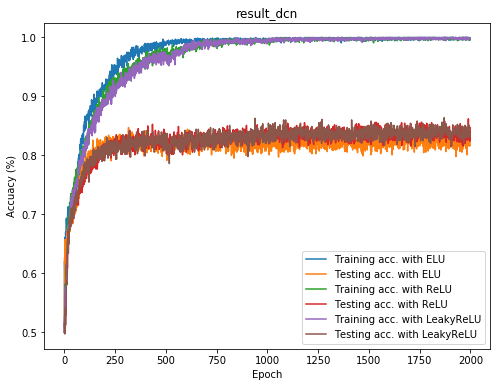

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
ACC_ = []

for activation_type in range(3):
    model = DCN(activation_type, fout=150, k1=11, k2=2, k3=11, k4=11, k5=12)
    model.to(device)
    # Define optimizer and loss function
    Loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    train_acc = []
    test_acc = []
    acc_max = 0.8
    for i in range(1, epoch+1):
        start = time.time()
        # adjust learning rate
        adjust_learning_rate(optimizer, i)
        train(model, i)
        print("-----------------------------------------------------------")
        acc = test(model, i, activation_type, "Train")
        train_acc.append(acc)
        acc = test(model, i, activation_type, "Test")
        test_acc.append(acc)
        print("-----------------------------------------------------------")
        if activation_type == 0:
            activation_str = "ELU"
        elif activation_type == 1:
            activation_str = "ReLU"
        else:
            activation_str = "LeakyReLU"
        train_str = "Training acc. with " + activation_str
        test_str = "Testing acc. with " + activation_str
        if acc > acc_max:
            path = "model/dcn_activation_" + activation_str + "_iteration_{}_acc_{:.3f}_lr_{}.pth".format(
                i, acc, lr)
            torch.save(model, path)
            acc_max = acc
        calc_time = time.time()-start # second
        remain = calc_time * ((epoch-i) + (2-activation_type)*epoch) # second
        print("acc_max is now: {}, ETA: {} min".format(acc_max, remain/60))
    ACC_.append(train_acc)
    ACC_.append(test_acc)
    ax.plot(train_acc, label=train_str)
    ax.plot(test_acc, label=test_str)    
ax.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Accuacy (%)")
plt.title("result_dcn")
plt.savefig("result_dcn.png")
plt.show()

In [28]:
acc_ = np.array(ACC_)
print(np.max(acc_[1]))
print(np.max(acc_[3]))
print(np.max(acc_[5]))

0.8481481481481481
0.862037037037037
0.8638888888888889


In [31]:
f1 = 16
f2 = 32
fout = 32
k1 = 51
k2 = 2
k3 = 16
do = 0.25
eeg = EEGNet(activation_type, f1, f2, fout)
eeg.to(device)

EEGNet(
  (firstConv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25)
  )
  (classify): Sequential(
    (0): Linear(in_features=736, out_features=2, bias=True)
  )
)

In [34]:
class DeepConvNet(torch.nn.Module):
    def __init__(self, activation, f1=25, f2=25, f3=50, f4 = 100, fout=200, 
                 k1=5, k2=2, k3=5, k4=5, k5=5, do=0.5):
        super(DeepConvNet, self).__init__()
        # Activation:
        #   0 -> ELU
        #   1 -> ReLU
        #   2 -> LeakyReLU
        conv1 = nn.Conv2d(1, f1, kernel_size = (1, k1))
        conv2 = nn.Conv2d(f1, f2, kernel_size = (k2, 1))
        conv3 = nn.Conv2d(f2, f3, kernel_size = (1, k3))
        conv4 = nn.Conv2d(f3, f4, kernel_size = (1, k4))
        conv5 = nn.Conv2d(f4, fout, kernel_size = (1, k5))
        dropout = nn.Dropout(p=do)
        maxpool = nn.MaxPool2d(kernel_size = (1, 2))
        batch_norm_1 = nn.BatchNorm2d(f1)
        batch_norm_2 = nn.BatchNorm2d(f3)
        batch_norm_3 = nn.BatchNorm2d(f4)
        batch_norm_4 = nn.BatchNorm2d(fout)
        if activation == 0:
            activation = nn.ELU()
        elif activation == 1:
            activation = nn.ReLU()
        else:
            activation = nn.LeakyReLU()
        
        self.net1 = nn.Sequential(
            conv1, conv2, batch_norm_1, activation, maxpool, dropout)
        self.net2 = nn.Sequential(
            conv3, batch_norm_2, activation, maxpool, dropout)
        self.net3 = nn.Sequential(
            conv4, batch_norm_3, activation, maxpool, dropout)
        self.net4 = nn.Sequential(
            conv5, batch_norm_4, activation, maxpool, dropout)
        self.classify = nn.Sequential(nn.Linear(fout*37, 2))
        
    def forward(self, x):
        res = self.net_1(x)
        res = self.net_2(res)
        res = self.net_3(res)
        res = self.net_4(res)
        res = res.view(res.size(0), -1) # Flatten
        res = self.classify(res)
        return res

In [35]:
dcn =  DeepConvNet(activation_type, fout=150, k1=11, k2=2, k3=11, k4=11, k5=12)
dcn.to(device)

DeepConvNet(
  (net1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 11), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5)
  )
  (net2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 11), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5)
  )
  (net3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 11), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 